In [1]:
import numpy as np
import pandas as pd
from dimod import Binary
import networkx as nx
import time
import random
from dimod import ConstrainedQuadraticModel
from dwave.system.samplers import LeapHybridCQMSampler
from dimod.binary import quicksum
from copy import deepcopy
from collections import Counter
from itertools import groupby
import matplotlib.pyplot as plt

C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (None) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


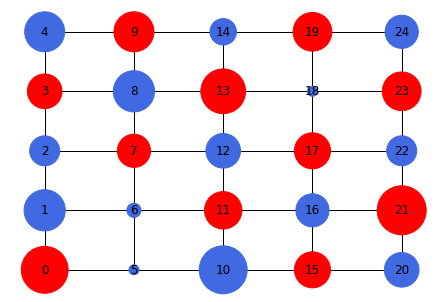

In [55]:
G= nx.Graph()
for i in range(5):
    for j in range(5):
        G.add_node(5*i+j,pos=(i,j))
for i in range(5):
    for j in range(4):
        G.add_edge(5*i+j,5*i+j+1,weight=5)
for j in range(5):
    for i in range(4):
        G.add_edge(5*i+j,5*(i+1)+j,weight=5)
pos=nx.get_node_attributes(G,'pos')
colormap=["royalblue"]*25
for i in loc2:
    colormap[i] ="red"
nx.draw(G,pos,with_labels=True,node_size = 100*W_loc,node_color=colormap)

In [44]:
def calc_dist(x,y):
    return np.sqrt((x%5-y%5)**2+(x//5-y//5)**2)
calc_dist(7,19)

2.8284271247461903

In [47]:
D5 = np.zeros((25,25))
for i in range(25):
    for j in range(i+1,25):
        D5[i,j] = 5*calc_dist(i,j)
        D5[j,i] = 5*calc_dist(i,j)

In [48]:
N = 25 
W_loc = np.random.randint(1,25,25)
radius = 6
loc2 = choose_location(N,W_loc,D5,radius)

In [51]:
np.sum([W_loc[i] for i in loc2])

175

In [56]:
np.sum([W_loc[i] for i in [0,2,4,6,8,10,12,14,16,18,20,22,24]])
np.sum([W_loc[i] for i in [2*n+1 for n in range(12)]])

171

In [33]:
#Use weighted maximal independent set criterion to choose location of stations
def choose_location(N,W_loc,D,radius):
    
    cqm = ConstrainedQuadraticModel()
    
    x = np.array([Binary(i) for i in range(N)])
    
    objective = quicksum(-W_loc*x)  #Wanna maximize the chosen weight
    cqm.set_objective(objective)
    
    for i in range(N):
        for j in range(i+1,N):
            if D[i,j] < radius:
                cqm.add_constraint(x[i]*x[j] == 0)
                
    token = "DEV-1dce3b9188c2ff50006a0512a0184002b14b4169"
    cqm_sampler = LeapHybridCQMSampler(token=token)
    sampleset = cqm_sampler.sample_cqm(cqm,label="choose_location")
    feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)
    
    best_index = np.argmin(feasible_sampleset.record.energy)
    best_sol = feasible_sampleset.record[best_index][0]
    
    chosen_stations = np.where(best_sol == 1)[0]
    
    return chosen_stations

In [64]:
def calc_dist(x,y,n):  #n is the side length of the square
    return np.sqrt((x%n-y%n)**2+(x//n-y//n)**2)
calc_dist(7,19,10)

2.23606797749979

In [65]:
D100 = np.zeros((100,100))
for i in range(100):
    for j in range(i+1,100):
        D100[i,j] = 5*calc_dist(i,j,10)  #each edge is of length 5
        D100[j,i] = 5*calc_dist(i,j,10)

In [66]:
N = 100 
W_loc100 = np.random.randint(1,50,100)
radius = 6
loc100 = choose_location(N,W_loc100,D100,radius)

In [62]:
loc100

array([ 1,  4,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36,
       38, 40, 42, 44, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75,
       77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99], dtype=int64)

In [63]:
D100[4,14]

10.0

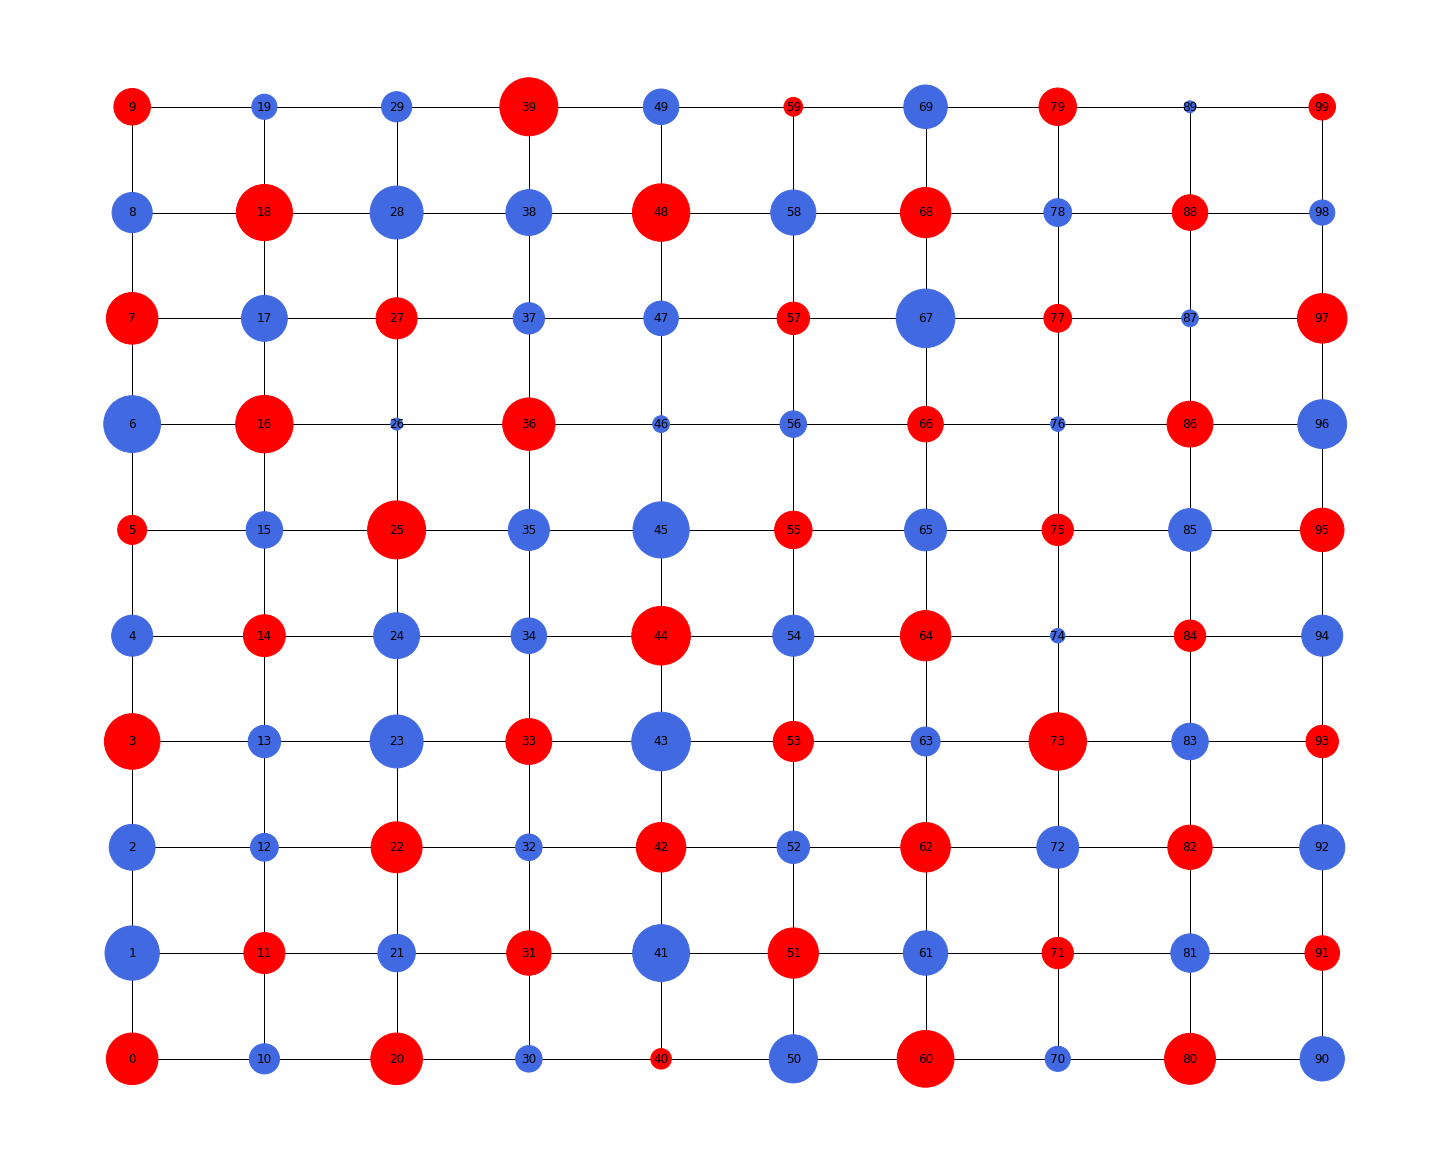

In [72]:
G100= nx.Graph()
for i in range(10):
    for j in range(10):
        G100.add_node(10*i+j,pos=(i,j))
for i in range(10):
    for j in range(9):
        G100.add_edge(10*i+j,10*i+j+1,weight=5)
for j in range(10):
    for i in range(9):
        G100.add_edge(10*i+j,10*(i+1)+j,weight=5)
pos=nx.get_node_attributes(G100,'pos')
colormap=["royalblue"]*100
for i in loc100:
    colormap[i] ="red"
fig = plt.figure(figsize=(20,16))
nx.draw(G100,pos,with_labels=True,node_size = 70*W_loc100,node_color=colormap)
plt.savefig(fname="choose_locations.png")

In [34]:
N = 100 
W_loc = np.random.randint(1,50,100)
D = np.random.randint(1,100,size=(100,100))
radius = 10
loc1 = choose_location(N,W_loc,D,radius)

In [40]:
optimal = np.sum([W_loc[i] for i in loc1])
valid = np.array([D[loc1[i],loc1[j]] for i in range(30) for j in range(i+1,30)])-10*np.ones(435)
np.where(valid<0)

(array([], dtype=int64),)

In [2]:
#First divide all the stations into 2 or 2^n groups to reduce problem size
def divide_region(N,We):
    
    cqm = ConstrainedQuadraticModel()
    
    W = np.array([We[j][i] if i>j else We[i][j] for i in range(N) for j in range(N)]).reshape(N,N)
    W[range(N),range(N)] = 0 #diaganol element = 0
    
    x = np.array([Binary(i) for i in range(N)])
    
    #Minimize the overall distance of subgraph1 + overall distance of subgraph2
    objective = 0.5*np.dot(1-x,np.dot(W,(1-x).transpose()))+0.5*np.dot(x,np.dot(W,x.transpose()))
    
    cqm.set_objective(objective)
    
    #cqm.add_constraint(0.5*np.dot(1-x,np.dot(W,(1-x).transpose()))-0.5*np.dot(x,np.dot(W,x.transpose()))>=0)
    
    cqm.add_constraint(quicksum([x[i] for i in range(N)]) == int(N/2))
    
    token = "DEV-1dce3b9188c2ff50006a0512a0184002b14b4169"
    cqm_sampler = LeapHybridCQMSampler(token=token)
    sampleset = cqm_sampler.sample_cqm(cqm,label="stations_division")
    feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)
    
    best_index = np.argmin(feasible_sampleset.record.energy)
    best_sol = feasible_sampleset.record[best_index][0]
    
    group1 = np.where(best_sol == 0)[0]
    group2 = np.where(best_sol == 1)[0]
    
    return [group1,group2]


In [252]:
W100 = np.random.randint(1,100,size=(100,100))
divide100 = divide_region(100,W100)

In [265]:
np.sum([W100[divide100[0][i],divide100[0][j]] for i in range(50) for j in range(i+1,50)])

55095

In [266]:
np.sum([W100[divide100[1][i],divide100[1][j]] for i in range(50) for j in range(i+1,50)])

57226

In [268]:
np.sum(W100[np.triu_indices(100)])

253425

In [274]:
len(divide100[0])

50

In [253]:
divide100

[array([ 6,  9, 11, 12, 16, 19, 25, 29, 30, 31, 34, 35, 37, 38, 40, 41, 42,
        43, 44, 45, 46, 48, 50, 52, 53, 57, 59, 60, 63, 64, 67, 68, 69, 70,
        72, 77, 80, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 99],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  7,  8, 10, 13, 14, 15, 17, 18, 20, 21, 22,
        23, 24, 26, 27, 28, 32, 33, 36, 39, 47, 49, 51, 54, 55, 56, 58, 61,
        62, 65, 66, 71, 73, 74, 75, 76, 78, 79, 81, 82, 89, 94, 96, 98],
       dtype=int64)]

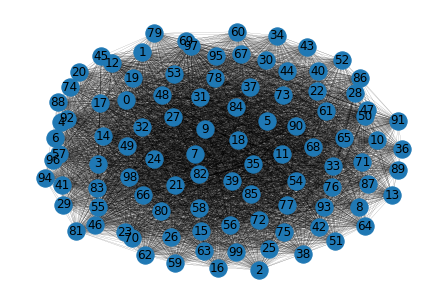

In [257]:
G100 = nx.Graph()
n =100
for i in range(n):
    G100.add_node(i)
for j in range(n):
    for k in range(j+1,n):
        G100.add_edge(j,k)
for i in range(n):
    for j in range(i+1,n):
        G100[i][j]["weight"] = W100[i][j]
        
pos100 = nx.spring_layout(G100,weight="length") #weight="length" positions the nodes at correct relative distances
plt.figure(figsize=(6,4))
nx.draw(G100,pos = pos100,with_labels=True,width=0.1)

In [699]:
subgroup1

array([ 2, 10, 13, 16, 26, 27, 36, 39, 46, 47, 49, 50, 52, 53, 54, 55, 74,
       77, 79, 81, 84, 86, 89, 95, 98], dtype=int64)

In [698]:
subgroup2

array([11, 17, 18, 28, 30, 32, 33, 34, 37, 38, 40, 42, 48, 56, 59, 71, 72,
       82, 85, 90, 91, 93, 96, 97, 99], dtype=int64)

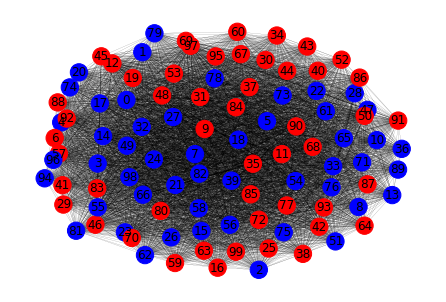

In [273]:
g_div = nx.Graph()
n=100
for i in range(n):
    g_div.add_node(i)
for j in range(n):
    for k in range(j+1,n):
        g_div.add_edge(j,k)
        
for i in range(n):
    for j in range(i+1,n):
        g_div[i][j]["weight"] = W100[i][j]

color_map = ["blue"]*100
for i in divide100[0]:
    color_map[i] = "red"  

plt.figure(figsize=(6,4))
nx.draw(g_div,pos = pos100,node_color = color_map,with_labels=True,width=0.1)

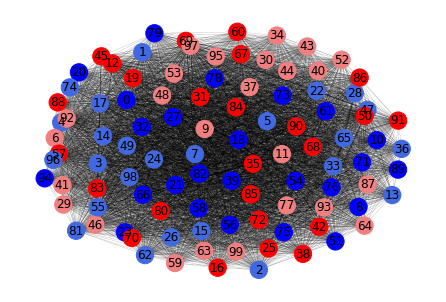

In [279]:
g_div2 = nx.Graph()
n=100
for i in range(n):
    g_div2.add_node(i)
for j in range(n):
    for k in range(j+1,n):
        g_div2.add_edge(j,k)
        
for i in range(n):
    for j in range(i+1,n):
        g_div2[i][j]["weight"] = W100[i][j]

color_map = ["blue"]*100
for i in subgroup1:
    color_map[i] = "red" 
for i in subgroup2:
    color_map[i] = "lightcoral" 
for i in subgroup3:
    color_map[i] = "royalblue" 


plt.figure(figsize=(6,4))
nx.draw(g_div2,pos = pos100,node_color = color_map,with_labels=True,width=0.1)

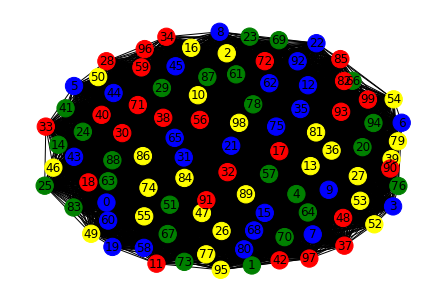

In [705]:
g_div = nx.Graph()
n=100
for i in range(n):
    g_div.add_node(i)
for j in range(n):
    for k in range(j+1,n):
        g_div.add_edge(j,k)
        
for i in range(n):
    for j in range(i+1,n):
        g_div[i][j]["weight"] = W100[i][j]

color_map = ["blue"]*100
for i in subgroup1:
    color_map[i] = "yellow" 
for i in subgroup2:
    color_map[i] = "red" 
for i in subgroup3:
    color_map[i] = "green" 
#for node in g_div:
    #if node in subgroup1:
        #color_map.append('green')
    #if node in subgroup2:
        #color_map.append('yellow')
    #if node in subgroup3:
        #color_map.append('red')
    #else: 
        #color_map.append('blue')

pos100 = nx.spring_layout(g_div,weight="length") #weight="length" positions the nodes at correct relative distances
plt.figure(figsize=(6,4))
nx.draw(g_div,pos = pos100,node_color = color_map,with_labels=True)

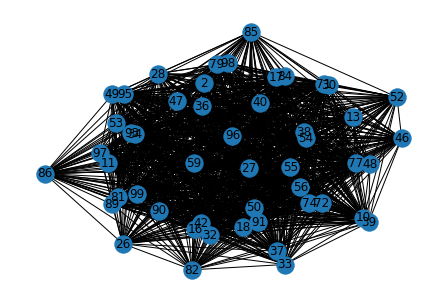

In [703]:
nx.draw(g_div.subgraph(divide100[0][0]),with_labels=True)

In [258]:
def make_W(W,nodes):
    w = [0 if (i>j) or (i==j) else W[nodes[i]][nodes[j]] for i in range(len(nodes)) for j in range(len(nodes))]
    w = np.array(w).reshape(len(nodes),len(nodes))
    return w

In [675]:
W100[10][11]

25

In [259]:
group1 = make_W(W100,divide100[0])
group2 = make_W(W100,divide100[1])
divide50_1 = divide_region(50,group1)
divide50_2 = divide_region(50,group2)
subgroup1 = divide100[0][divide50_1[0]]
subgroup2 = divide100[0][divide50_1[1]]

In [260]:
subgroup3 = divide100[1][divide50_2[0]]
subgroup4 = divide100[1][divide50_2[1]]

In [386]:
set(list(subgroup1)+list(subgroup2)+list(subgroup3)+list(subgroup4)) == set(range(100))

True

In [389]:
smaller_graphs = [G100.subgraph(sub) for sub in [subgroup1,subgroup2,subgroup3,subgroup4]]
[nx.is_connected(graph)for graph in smaller_graphs]

[True, True, True, True]

In [390]:
distance_matrices = [make_W(W100,nodes) for nodes in [subgroup1,subgroup2,subgroup3,subgroup4]]
w100 = np.random.randint(1,25,100)
traffic_volumes = [w100[sub] for sub in [subgroup1,subgroup2,subgroup3,subgroup4]]

Important Line, dont move

In [406]:
graph100_25 = [mini_overall_dist(25,distance_matrices[i],traffic_volumes[i]) for i in range(4)]

C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [422]:
#This one was empty on previous run
graph100_25_1 = mini_overall_dist(25,distance_matrices[1],traffic_volumes[1])

C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [426]:
#graph100_25_1 is added to the original subnetworks solutions
graph100_25[1] = graph100_25_1

In [451]:
len(graph100_25[0])
len(connected_graph(25,graph100_25[0]))

4

In [453]:
[avg_path_length(25,graph100_25[i],distance_matrices[i]) for i in range(4)] 

[[153.12666666666667,
  31.433333333333334,
  17.426666666666666,
  41.04666666666667],
 [40.18, 44.873333333333335],
 [16.813333333333333,
  13.486666666666666,
  17.913333333333334,
  16.766666666666666,
  14.686666666666667,
  15.84,
  159.22],
 [32.11333333333334,
  13.126666666666667,
  14.32,
  24.113333333333333,
  31.626666666666665,
  20.98]]

In [454]:
[overall_length(distance_matrices[i],graph100_25[i]) for i in range(4)]

[[884, 156, 101, 173],
 [162, 252],
 [89, 86, 90, 121, 87, 90, 837],
 [158, 81, 84, 178, 181, 129]]

In [435]:
best_index = [np.argmin(overall_length(distance_matrices[i],graph100_25[i])) for i in range(4)]

In [436]:
best_subnetworks = [graph100_25[i][best_index[i]] for i in range(4)]

In [463]:
#map the index of best_subnetworks to the actual index
subgroups=[subgroup1,subgroup2,subgroup3,subgroup4]
subnetworks = [[(subgroups[i][edge[0]],subgroups[i][edge[1]]) for edge in sub] for i,sub in enumerate(best_subnetworks)]

In [466]:
g100_25 = [make_nx_graph(25,subnetworks[i],W100,subgroups[i]) for i in range(4)]

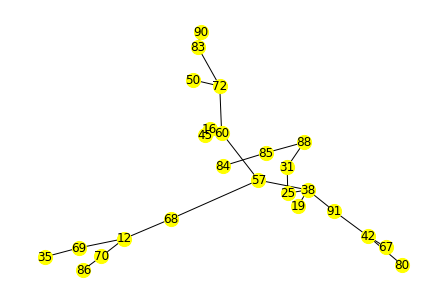

In [543]:
nx.draw(g100_25[0],pos=pos_final,with_labels=True,node_color="yellow",node_size=200)

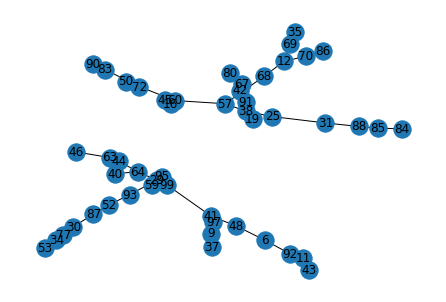

In [473]:
F12 = nx.union(g100_25[0],g100_25[1])
nx.draw(F12,with_labels=True)

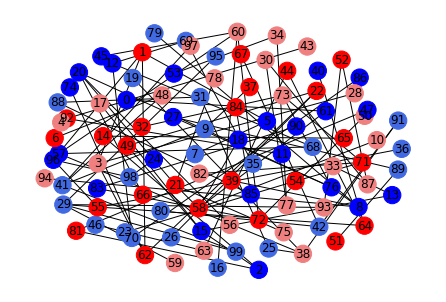

In [503]:
F12 = nx.union(g100_25[0],g100_25[1])
F123 = nx.union(F12,g100_25[2])
discon100 = nx.union(F123,g100_25[3])
#discon100 = nx.union_all(g100_25)
color_map = ["blue"]*100
for i in subgroup1:
    color_map[i] = "red" 
for i in subgroup2:
    color_map[i] = "lightcoral" 
for i in subgroup3:
    color_map[i] = "royalblue"
nx.draw(discon100,pos=pos100,node_color=color_map,with_labels=True)

In [481]:
10//3

3

In [482]:
avg =[]
for i in list(g100_25[0].nodes):
    for j in list(g100_25[1].nodes):
        F12 = nx.union(g100_25[0],g100_25[1])
        F12.add_edge(i,j,weight=W100[i,j])
        avg.append(nx.average_shortest_path_length(F12,weight="weight"))
mini = np.argmin(avg)
con1 = list(g100_25[0].nodes)[mini//25]
con2 = list(g100_25[1].nodes)[mini%25]

In [487]:
new_connection = []
for k in range(4):
    for s in range(k+1,4):
        avg =[]
        for i in list(g100_25[k].nodes):
            for j in list(g100_25[s].nodes):
                F12 = nx.union(g100_25[k],g100_25[s])
                F12.add_edge(i,j,weight=W100[i,j])
                avg.append(nx.average_shortest_path_length(F12,weight="weight"))
        mini = np.argmin(avg)
        con1 = list(g100_25[k].nodes)[mini//25]
        con2 = list(g100_25[s].nodes)[mini%25]
        new_connection.append((con1,con2))
new_connection

[(88, 29), (38, 62), (72, 66), (29, 81), (29, 73), (49, 20)]

In [493]:
g_final = nx.union_all(g100_25)
weights = [W100[i,j] for i,j in new_connection]
for index,edge in enumerate(new_connection):
    g_final.add_edge(edge[0],edge[1],weight=weights[index])

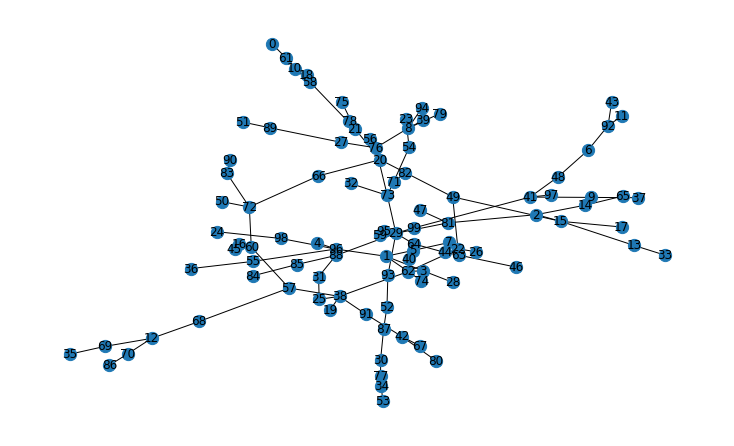

In [534]:
#pos_final = nx.spring_layout(g_final)
color_map = ["royalblue"]*100
for i in subgroup1:
    color_map[i] = "yellow" 
for i in subgroup2:
    color_map[i] = "red" 
for i in subgroup3:
    color_map[i] = "green" 
plt.figure(figsize=(10,6))
nx.draw(g_final,pos = pos_final, with_labels=True,node_size=150)

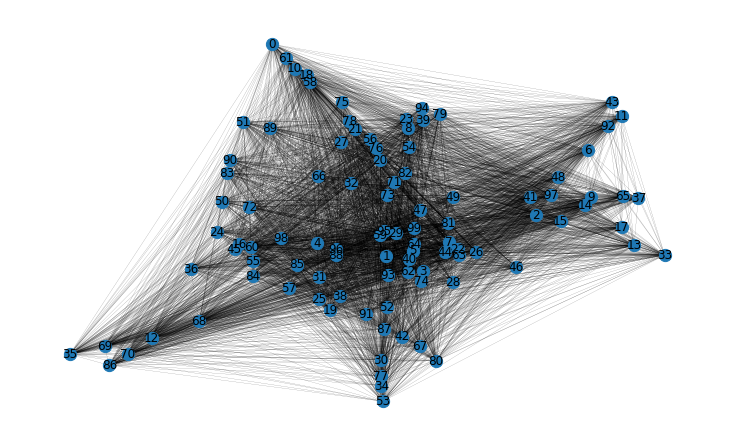

In [539]:
Gg100 = nx.Graph()
for i in range(100):
    Gg100.add_node(i)
for i in range(100):
    for j in range(i+1,100):
        Gg100.add_edge(i,j,weight=W100[i][j])
plt.figure(figsize=(10,6))
nx.draw(Gg100,pos = pos_final, with_labels=True,node_size=150,width=0.1)

In [552]:
nx.average_shortest_path_length(g_final,weight="weight")
#np.sum([W100[u,v] for u,v in list(g_final.edges)])
#len(g_final.edges)

27.79050505050505

In [544]:
np.sum(W100[np.triu_indices(100)])

253425

In [10]:
ad = np.array([[0,1,1,1],
               [1,0,1,1],
              [1,1,0,1],
              [1,1,1,0]])

power = [np.linalg.matrix_power(ad, k) for k in range(1,4)]
summ = 0
for p in power:
    summ += p
validity = np.prod(summ)
summ

array([[ 9, 10, 10, 10],
       [10,  9, 10, 10],
       [10, 10,  9, 10],
       [10, 10, 10,  9]])

In [20]:
np.prod(np.array([np.prod(summ[i,:]) for i in range(summ.shape[0])]))

-631304192

In [11]:
np.prod(np.array([1,2,3,4]))

24

In [2]:
def connected_graph(n,graph_list):
    
    valid_graph = []
    for graph in graph_list:
    
        adjacent = np.zeros((n,n))
        for edge in graph:
            adjacent[edge[0],edge[1]] = 1
            adjacent[edge[1],edge[0]] = 1
        
        power = [np.linalg.matrix_power(adjacent, k) for k in range(1,n)]
        summ = 0
        for p in power:
            summ += p
        validity = np.prod(summ)
        if validity != 0:
            valid_graph.append(graph)
    return valid_graph

In [3]:
def mini_overall_dist(n,We,Wn):
    
    cqm = ConstrainedQuadraticModel()
    
    largest = np.argsort(Wn)[-1:-1-round(0.1*n):-1]
    smallest = np.argsort(Wn)[:round(0.1*n)]
    
    x=[0 if (i>j) or (i==j) else Binary(f"x{i}{j}") for i in range(n) for j in range(n)]
    x = np.array(x).reshape(n,n)
    x = [x[j][i] if i>j else x[i][j] for i in range(n) for j in range(n)]
    x = np.array(x).reshape(n,n)
    
    dist = quicksum(We[np.triu_indices(n)]*x[np.triu_indices(n)])
    cqm.set_objective(dist)
    
    #Each station needs to be connected at least once
    for i in range(n):
        cqm.add_constraint(quicksum([x[i,j] for j in range(n)]) >= 1)
    # For any connected pair, at least one node of the pair needs to connect with another node
    for i in range(n):
        for j in range(i+1,n):
            cqm.add_constraint(x[i,j]-quicksum([x[i,s]+x[j,k] for s in range(n) for k in range(n) if (s!=j) and (k!=i)])<=0)
    #For any connected trio, at least one node of the trio needs to connect with another node (very costly)
    #for i in range(n):
        #for j in range(i+1,n):
            #for k in range(j+1,n):
                #cqm.add_constraint(x[i,j]*x[j,k]-quicksum([x[i,s]+x[j,t]+x[k,u] for s in range(n) for t in range(n) for u in range(n) if (s not in [j,k]) and (t not in [i,k]) and (u not in [i,j])])<=0)
    # Total edges needs to be greater or equal to n-1
    #cqm.add_constraint(0.5*quicksum([quicksum([x[i,j] for j in range(n)]) for i in range(n)]) >= n-1)
    cqm.add_constraint(quicksum(x[np.triu_indices(n)]) >= n-1)  #not useful cuz constarint 1 already covers this
    
    #Top 10% largest station needs at least 4 connections(edges) (two lines)
    for i in largest:
        cqm.add_constraint(quicksum([x[i,j] for j in range(n)]) >= 4)
            
    #Bottom 10% smallest station cannot have more than 2 connections
    for i in smallest:
        cqm.add_constraint(quicksum([x[i,j] for j in range(n)]) <= 2)
    
    #No station can have 3 connections
    #for i in range(n):
        #cqm.add_constraint((quicksum([x[i,j] for j in range(n)])-3)**2 >= 1)
        
    token = "DEV-1dce3b9188c2ff50006a0512a0184002b14b4169"
    cqm_sampler = LeapHybridCQMSampler(token=token)
    sampleset = cqm_sampler.sample_cqm(cqm,label="Metro_Planning")
    
    data = pd.DataFrame([sampleset.record[i][0] for i in range(len(sampleset.record))],columns=sampleset.variables)
    
    #Take out samples that fulfill the constraints and are connected graph
    feasible_index = np.where(sampleset.record.is_feasible == True)[0]
    
    #connectivity constraint
    #connected_index = []
    #for index in feasible_index:
        #feasible_sol = data.iloc[index,:]
        #value_dict = dict(feasible_sol)
        
        #solution=[0 if (i>j) or (i==j) else value_dict[f"x{i}{j}"] for i in range(n) for j in range(n)]
        #sol = np.array(solution).reshape(n,n)
        #sol = [sol[j][i] if i>j else sol[i][j] for i in range(n) for j in range(n)]
        #sol = np.array(sol).reshape(n,n)  #sol is the adjacent matrix
        
        #power = [np.linalg.matrix_power(sol, k) for k in range(1,n)]
        #summ = 0
        #for p in power:
            #summ += p
        #validity = np.prod(summ)
        #if validity != 0:
            #connected_index.append(index)
            
    #connection = np.array(connected_index)
    
    #optimal_index = np.where(sampleset.record[feasible_index].energy == np.min(sampleset.record[feasible_index].energy))[0]
    #optimal_sol = data.iloc[feasible_index[optimal_index][0],:]
    optimal_sol = data.iloc[feasible_index,:]
    
    
    #Convert the ouput variables into the correct order
    #value_dict = dict(optimal_sol)
    value_dict = [dict(optimal_sol.iloc[i,:]) for i in range(optimal_sol.shape[0])]
    graph_list = [[(i,j) for i in range(n) for j in range(i+1,n) if value[f"x{i}{j}"]==1] for value in value_dict]
    
    #graph = []
    #for value in value_dict:
        #chosen_edges = []
        #for key,item in value.items():
            #if item == 1:
                #chosen_edges.append(key)
        #graph.append(chosen_edges)
            
    #graph_list = [[(int(edge[1]),int(edge[2])) for edge in chosen_edges] for chosen_edges in graph]
    graph_list = [k for k,v in groupby(sorted(graph_list))]  #remove repeated graphs
    
    #extract graph that satisfies the connectivity check
    connected_graph_list = connected_graph(n,graph_list)
    
    return connected_graph_list

In [4]:
def overall_length(W,graph_list):
    return [np.sum([W[edge[0],edge[1]] for edge in graph]) for graph in graph_list]

In [422]:
n = 4
W = np.array([[0,1,2,3],
              [1,0,4,5],
             [2,4,0,6],
             [3,5,6,0]])
w = np.array([3,4,1,6])
test = mini_overall_dist(n,W,w)

In [423]:
test

[[(0, 1), (0, 2), (1, 3)], [(0, 1), (0, 3), (1, 2)]]

In [136]:
## a good way to remove repeated graphs in the graph list
values = deepcopy(test[0])
from itertools import groupby
graph_list = [k for k,v in groupby(sorted(values))]

In [137]:
adjacent_list=[]
for graph in graph_list:
    adjacent = np.zeros((4,4))
    for edge in graph:
        adjacent[edge[0],edge[1]] = 1
        adjacent[edge[1],edge[0]] = 1
    adjacent_list.append(adjacent)
adjacent_list

[array([[0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])]

In [149]:
W*adjacent_list[0]

array([[0., 1., 2., 3.],
       [1., 0., 0., 0.],
       [2., 0., 0., 0.],
       [3., 0., 0., 0.]])

In [146]:
connection_dict = []
for ad in adjacent_list:
    connection_dict.append({i:np.where(ad[i,:] == 1)[0] for i in range(ad.shape[0])})
connection_dict[0]

{0: array([1, 2, 3], dtype=int64),
 1: array([0], dtype=int64),
 2: array([0], dtype=int64),
 3: array([0], dtype=int64)}

In [424]:
n = 10
W10_2 = np.random.randint(1,10,size=(10,10))
w10_2 = np.random.randint(1,10,10)
solu2 = mini_overall_dist(n,W10_2,w10_2)

C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [425]:
solu2

[[(0, 1),
  (0, 4),
  (0, 6),
  (0, 9),
  (1, 2),
  (1, 3),
  (1, 5),
  (3, 4),
  (3, 5),
  (3, 9),
  (4, 8),
  (4, 9),
  (5, 7),
  (5, 9)],
 [(0, 1), (0, 4), (0, 6), (0, 9), (1, 2), (1, 3), (1, 5), (4, 8), (7, 8)],
 [(0, 1),
  (0, 4),
  (0, 6),
  (0, 9),
  (1, 2),
  (1, 5),
  (1, 7),
  (2, 3),
  (2, 6),
  (2, 7),
  (7, 8),
  (7, 9)],
 [(0, 1), (0, 4), (0, 6), (0, 9), (1, 2), (1, 5), (1, 8), (3, 9), (7, 8)],
 [(0, 1),
  (0, 4),
  (0, 6),
  (0, 9),
  (1, 3),
  (1, 5),
  (1, 6),
  (2, 6),
  (6, 8),
  (7, 8)],
 [(0, 1), (0, 4), (0, 6), (0, 9), (1, 3), (1, 5), (1, 8), (2, 6), (7, 8)],
 [(0, 1),
  (0, 4),
  (0, 6),
  (0, 9),
  (1, 5),
  (2, 3),
  (2, 5),
  (2, 6),
  (2, 9),
  (3, 5),
  (3, 7),
  (3, 9),
  (5, 7),
  (7, 8),
  (7, 9)],
 [(0, 1), (0, 4), (0, 6), (0, 9), (1, 5), (2, 4), (3, 4), (4, 8), (7, 8)],
 [(0, 1), (0, 4), (0, 6), (0, 9), (1, 5), (2, 6), (3, 5), (4, 8), (7, 8)],
 [(0, 1), (0, 4), (0, 6), (0, 9), (1, 5), (2, 6), (3, 9), (4, 8), (7, 8)],
 [(0, 1), (0, 4), (0, 6), (0, 9), (1

In [236]:
n = 10
W10 = np.random.randint(0,10,size=(10,10))
#W10 = (W10+W10.transpose())/2
#for i in range(10):
    #W10[i,i] = 0
w10 = np.random.randint(1,10,10)
solu = mini_overall_dist(n,W10,w10)
solu[0]

[(0, 2), (0, 9), (1, 9), (3, 5), (4, 6), (4, 9), (5, 7), (6, 8), (7, 9)]

In [247]:
n = 10
A10 = np.random.randint(0,10,size=(10,10))
solu_con = mini_overall_dist(n,A10,w10)
solu_con

[[(0, 1),
  (0, 5),
  (1, 8),
  (1, 9),
  (2, 6),
  (3, 9),
  (4, 8),
  (4, 9),
  (5, 7),
  (6, 8),
  (8, 9)],
 [(0, 1),
  (0, 5),
  (1, 8),
  (1, 9),
  (2, 6),
  (3, 9),
  (4, 9),
  (5, 7),
  (6, 8),
  (8, 9)],
 [(0, 1),
  (0, 5),
  (1, 9),
  (2, 6),
  (3, 9),
  (4, 8),
  (4, 9),
  (5, 7),
  (6, 8),
  (8, 9)],
 [(0, 1), (0, 5), (1, 9), (2, 6), (3, 9), (4, 9), (5, 7), (6, 8), (8, 9)],
 [(0, 1),
  (0, 9),
  (1, 8),
  (1, 9),
  (2, 6),
  (3, 4),
  (4, 9),
  (5, 7),
  (6, 8),
  (7, 8),
  (8, 9)],
 [(0, 1),
  (1, 8),
  (1, 9),
  (2, 6),
  (3, 9),
  (4, 8),
  (4, 9),
  (5, 7),
  (6, 8),
  (7, 8),
  (8, 9)],
 [(0, 1),
  (1, 8),
  (1, 9),
  (2, 6),
  (3, 9),
  (4, 9),
  (5, 7),
  (6, 8),
  (7, 8),
  (8, 9)],
 [(0, 1),
  (1, 9),
  (2, 6),
  (3, 9),
  (4, 8),
  (4, 9),
  (5, 7),
  (6, 8),
  (7, 8),
  (8, 9)],
 [(0, 1), (1, 9), (2, 6), (3, 9), (4, 9), (5, 7), (6, 8), (7, 8), (8, 9)],
 [(0, 5),
  (1, 8),
  (1, 9),
  (2, 6),
  (3, 9),
  (4, 8),
  (4, 9),
  (5, 7),
  (6, 8),
  (8, 9)],
 [(0, 5), (1

In [253]:
solu_con[0]

[(0, 1),
 (0, 5),
 (1, 8),
 (1, 9),
 (2, 6),
 (3, 9),
 (4, 8),
 (4, 9),
 (5, 7),
 (6, 8),
 (8, 9)]

In [255]:
[np.sum([A10[edge[0],edge[1]] for edge in graph]) for graph in solu_con]

[5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7]

In [251]:
len(connected_graph(n,solu_con))

11

In [237]:
solu

[[(0, 2), (0, 9), (1, 9), (3, 5), (4, 6), (4, 9), (5, 7), (6, 8), (7, 9)],
 [(0, 2), (0, 9), (1, 9), (3, 5), (4, 9), (5, 6), (5, 7), (6, 8), (7, 9)],
 [(0, 2), (0, 9), (1, 9), (3, 6), (4, 9), (5, 7), (5, 9), (6, 8)],
 [(0, 2), (0, 9), (1, 9), (3, 6), (4, 9), (5, 7), (6, 8), (7, 9)],
 [(0, 9), (1, 9), (2, 4), (3, 6), (4, 9), (5, 7), (6, 8), (7, 9)],
 [(0, 9), (1, 9), (2, 6), (3, 6), (4, 9), (5, 7), (6, 8), (7, 9)]]

In [238]:
w10

array([9, 2, 7, 9, 4, 5, 8, 1, 1, 9])

In [206]:
n = 10
W10_3 = np.random.randint(0,10,size=(10,10))
w10_3 = np.random.randint(1,10,10)
solu3 = mini_overall_dist(n,W10_3,w10_3)
solu3[0]

[[(0, 8), (1, 6), (2, 8), (3, 9), (4, 7), (5, 7), (6, 7), (6, 8), (7, 9)]]

In [587]:
n = 20
W20_2 = np.random.randint(5,15,size=(20,20))
w20_2 = np.random.randint(1,20,20)
start = time.time()
graph20_2 = mini_overall_dist(n,W20_2,w20_2)
end = time.time()
print("runtime:",end-start)

runtime: 69.68036317825317


C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [588]:
len(graph20_2)

17

In [211]:
W10_33 = (W10_3 + W10_3.transpose())/2
for i in range(10):
    W10_33[i,i] = 0
sym3 = mini_overall_dist(n,W10_33,w10_3)
sym3[0]

[]

In [87]:
chosen_edge = [(int(edge[1]),int(edge[2])) for edge in solu[0]]
chosen_edge

[(0, 1), (0, 7), (0, 9), (1, 3), (1, 5), (1, 8), (2, 7), (4, 7), (6, 8)]

In [72]:
w10

array([9, 9, 1, 6, 1, 6, 3, 6, 6, 3])

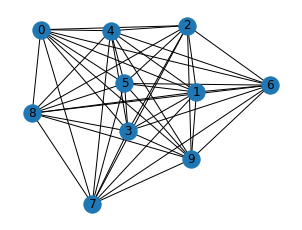

In [110]:
G = nx.Graph()
for i in range(n):
    G.add_node(i)
for j in range(n):
    for k in range(j+1,n):
        G.add_edge(j,k)

for i in range(n):
    for j in range(i+1,n):
        G[i][j]["weight"] = W10[i][j]
my_pos = nx.spring_layout(G, seed = 30)
plt.figure(figsize=(4,3))
nx.draw(G,pos = my_pos,with_labels=True)

In [23]:
n = 30
W30 = np.random.randint(1,15,size=(30,30))
w30 = np.random.randint(1,15,30)
start = time.time()
graph30 = mini_overall_dist(n,W30,w30)
end = time.time()
print("runtime:",end-start)

runtime: 50.743409156799316


C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [314]:
np.sum(W30[np.triu_indices(30)])

3582

In [26]:
overall_length(W30,graph30)

[63, 68, 61]

In [31]:
g30 = make_nx_graph(30,graph30[2],W30)

In [297]:
candidate_g30 = [make_nx_graph(30,i,W30) for i in graph30]
avg_path30 = avg_path_length(30,graph30,W30)
avg_path30

[13.00919540229885, 13.604597701149425, 11.404597701149426]

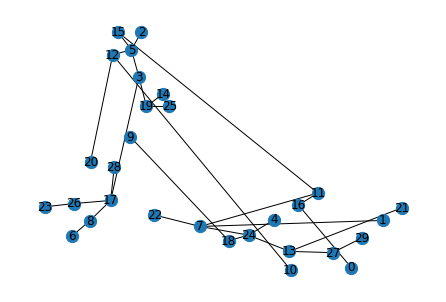

In [311]:
pos_comp = nx.spring_layout(g30,weight="length")
nx.draw(candidate_g30[0],pos = pos30,with_labels=True,node_size=150)

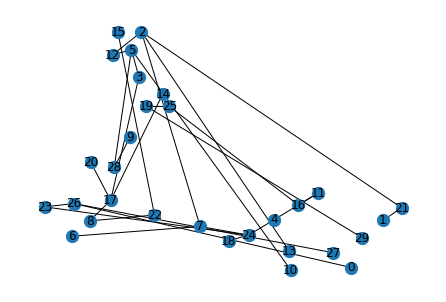

In [312]:
nx.draw(candidate_g30[1],pos = pos30,with_labels=True,node_size=150)

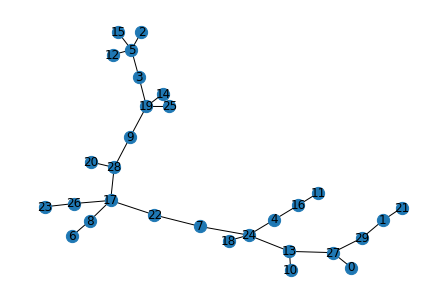

In [313]:
nx.draw(candidate_g30[2],pos = pos30,with_labels=True,node_size=150)

In [575]:
n = 30
W30_2 = np.random.randint(10,50,size=(30,30))
w30_2 = np.random.randint(1,10,30)
start = time.time()
graph30_2 = mini_overall_dist(n,W30_2,w30_2)
end = time.time()
print("runtime:",end-start)

runtime: 50.24362301826477


C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [579]:
graph30_2[2]

[(0, 25),
 (1, 17),
 (2, 8),
 (2, 20),
 (3, 14),
 (3, 16),
 (4, 18),
 (5, 7),
 (5, 29),
 (6, 25),
 (7, 22),
 (8, 9),
 (8, 18),
 (9, 15),
 (10, 16),
 (11, 16),
 (12, 14),
 (13, 20),
 (13, 29),
 (14, 17),
 (14, 20),
 (16, 28),
 (18, 19),
 (18, 26),
 (20, 21),
 (20, 24),
 (21, 23),
 (25, 29),
 (27, 28)]

In [576]:
len(graph30_2) 

3

In [578]:
overall_length(W30_2,graph30_2)

[359, 335, 332]

In [589]:
n = 30
W30_3 = np.random.randint(10,50,size=(30,30))
w30_3 = np.random.randint(1,10,30)
start = time.time()
graph30_3 = mini_overall_dist(n,W30_3,w30_3)
end = time.time()
print("runtime:",end-start)

runtime: 237.7583680152893


C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [590]:
len(graph30_3)

1

In [591]:
graph30_3[0]

[(0, 14),
 (0, 16),
 (1, 5),
 (1, 6),
 (1, 27),
 (2, 15),
 (2, 18),
 (2, 24),
 (3, 20),
 (4, 8),
 (4, 24),
 (5, 29),
 (7, 11),
 (7, 19),
 (7, 25),
 (7, 26),
 (8, 12),
 (9, 19),
 (10, 18),
 (11, 20),
 (11, 28),
 (13, 27),
 (16, 20),
 (17, 22),
 (18, 22),
 (18, 23),
 (20, 27),
 (21, 26),
 (23, 29)]

In [407]:
avg_length30 = avg_path_length(30,graph30,W30)

In [409]:
avg_length30

[6.820689655172414, 7.622988505747126, 20.97241379310345]

In [411]:
overall_length(W30,graph30)

[44, 44, 117]

In [413]:
np.mean(W30[np.triu_indices(30)])

7.559139784946237

In [6]:
def make_nx_graph(n,graph,W,nodes=range(n)):
    
    g = nx.Graph()
    for i in nodes:
        g.add_node(i)
    for j in graph:
        g.add_edge(j[0],j[1])
    
    for i in graph:
        g[i[0]][i[1]]["weight"] = W[i[0]][i[1]]
    return g 

NameError: name 'n' is not defined

In [5]:
def adjacent_matrix(graph,n):

    adjacent = np.zeros((n,n))
    for edge in graph:
        adjacent[edge[0],edge[1]] = 1
        adjacent[edge[1],edge[0]] = 1
    
    return adjacent

In [6]:
#This create a list of adjacent matrix
def adjacent_matrix(graph_list,n):
    adjacent_list=[]
    for graph in graph_list:
        adjacent = np.zeros((n,n))
        for edge in graph:
            adjacent[edge[0],edge[1]] = 1
            adjacent[edge[1],edge[0]] = 1
        adjacent_list.append(adjacent)
    return adjacent_list

In [148]:
def adjacent_dict(adjacent_list):
    
    connection_dict = []
    for ad in adjacent_list:
        connection_dict.append({i:np.where(ad[i,:] == 1)[0] for i in range(ad.shape[0])})
    return connection_dict

In [150]:
#This create a list of cost matrix
def cost_matrix(W,adjacent_list):
    cost_list = []
    for ad in adjacent_list:
        initial = W*ad
        inverse_ad =10000*(np.ones(W.shape) - ad) #if theres no connection, then the distance is set to be 10000
        cost_list.append(initial+inverse_ad)
    return cost_list

In [151]:
cost_matrix(W,adjacent_list)

[array([[1.e+04, 1.e+00, 2.e+00, 3.e+00],
        [1.e+00, 1.e+04, 1.e+04, 1.e+04],
        [2.e+00, 1.e+04, 1.e+04, 1.e+04],
        [3.e+00, 1.e+04, 1.e+04, 1.e+04]])]

Calculate shortest path length and average shortest path length

In [6]:
from networkx import average_shortest_path_length

In [295]:
average_shortest_path_length(g30,weight="weight")

11.404597701149426

In [ ]:
division = [subgroup1,subgroup2,subgroup3,subgroup4]
w_div=[make_W(W100,nodes) for nodes in division]
for graph in division:
    g = nx.Graph()
    for i in graph:
        g.add_node(i)
    for 
[average_shortest_path_length(g,weight="weight") for g in g_list]

In [7]:
def avg_path_length(n,graph_list,W):
    avg_path = []
    for graph in graph_list:
        g = nx.Graph()

        for i in range(n):
            g.add_node(i)
        for j in graph:
            g.add_edge(j[0],j[1])

        for i in graph:
            g[i[0]][i[1]]["weight"] = W[i[0]][i[1]]
            
        avg_path.append(nx.average_shortest_path_length(g,weight="weight"))
        
    return avg_path

In [355]:
avg_length20 = avg_path_length(20,connected_graph(20,graph20),W20)

In [321]:
g4 = nx.Graph()
n=4
for i in range(n):
    g4.add_node(i)
for j in range(1,n):
    g4.add_edge(0,j)

for i in range(1,n):
    g4[0][i]["weight"] = W[0][i]
    
average_shortest_path_length(g4)

1.5

In [347]:
nx.shortest_path_length(g, source=7, target=9, weight="weight") 

1

In [348]:
average_shortest_path_length(g,weight="weight")

3.022222222222222

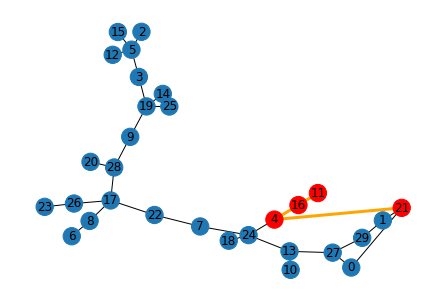

In [292]:
gtest = nx.Graph(g30)
gtest.add_edge(4,21,weight=8)
gtest.add_edge(0,21,weight=5)
node_colors = ["#1f78b4"]*30
node_colors[21] = "red"
node_colors[11] = "red"
node_colors[4] = "red"
node_colors[16] = "red"

edges = gtest.edges()
edge_colors = ["orange" if (u,v) in [(4,21),(4,16),(11,16)] else "black" for u,v in edges]
widths = [3 if (u,v) in [(4,21),(4,16),(11,16)] else 1 for u,v in edges]
nx.draw(gtest,pos=pos30,with_labels=True,node_color=node_colors,edge_color=edge_colors,width=widths)

In [285]:
n = 30
graph = list(gtest.edges)
ad30 = adjacent_matrix(list(gtest.edges),n)
ad30[4,21] = 1
ad30[21,4] = 1
ad30[0,21] =1
ad30[21,0] = 1
shortest_path(n,W30,graph,ad30,start=21,end=11)

[[21, 4, 16, 11], 10.0]

In [49]:
def shortest_path(n,We,graph,start,end):
    
    adjacent = adjacent_matrix(graph,n)
    
    for i in range(n):
        for j in range(i):
            We[i,j] = We[j,i]
    
    if adjacent[start,end] == 1:
        path = [start,end]
        if start > end:
            shortest_dist = We[end,start]
        else:
            shortest_dist = We[start,end]
    else:
        
        cqm = ConstrainedQuadraticModel()
    
        valid_weight = We*adjacent
            
        y = np.array([Binary(f"y{i}") if (i!=end) and (i!=start) else 1 for i in range(n)])
    
        path_length = 0.5*np.dot(y,np.dot(valid_weight,y.transpose()))
    
        cqm.set_objective(path_length)
    
        term1 = 0.5*np.dot(y,np.dot(adjacent,y.transpose()))
        term2 = quicksum([y[k] for k in range(n) if (k!=end) and (k!=start)])
        cqm.add_constraint(term1-term2 == 1)
        
        #end and start has exactly one connection with the chosen nodes
        cqm.add_constraint(quicksum([adjacent[start,k]*y[k] for k in range(n)]) == 1)
        cqm.add_constraint(quicksum([adjacent[end,k]*y[k] for k in range(n)]) == 1)
    
        token = "DEV-1dce3b9188c2ff50006a0512a0184002b14b4169"
        cqm_sampler = LeapHybridCQMSampler(token=token)
        sampleset = cqm_sampler.sample_cqm(cqm,label="shortest_path")
    
        data = pd.DataFrame([sampleset.record[i][0] for i in range(len(sampleset.record))],columns=sampleset.variables)
    
        #Take out samples that fulfill the constraints and are connected graph
        feasible_index = np.where(sampleset.record.is_feasible == True)[0]
        shortest_dist = np.min(sampleset.record[feasible_index].energy)
        optimal_index = np.where(sampleset.record[feasible_index].energy == np.min(sampleset.record[feasible_index].energy))[0]
        optimal_sol = data.iloc[feasible_index[optimal_index][0],:]
    
    
        #Convert the ouput variables into the correct order
        value_dict = dict(optimal_sol) 
        station = [start,end]
        for i in range(n):
            if (i!=end) and (i!=start):
                if (value_dict[f"y{i}"] == 1):
                    station.append(i)
                    
        path = [start]
        num = len(station)

        while len(path) < num:
            for s in station[1:]:
                if (adjacent[s,path[-1]] == 1) and (s not in path):
                    path.append(s)
        
        shortest_dist = np.sum([We[path[i],path[i+1]] for i in range(len(path)-1)])
        #station = [int(key[1]) for key,item in value_dict.items() if item==1]
        #station.append(start)
        #station.append(end)
    
    return [path,shortest_dist]

In [12]:
start = 2
n = 4
y = np.array([[Binary(f"y{i}{j}") if (j!=i) and (j!=start) else 1 for j in range(n)] for i in range(n) if i != start])
y

array([[1, BinaryQuadraticModel({'y01': 1.0}, {}, 0.0, 'BINARY'), 1,
        BinaryQuadraticModel({'y03': 1.0}, {}, 0.0, 'BINARY')],
       [BinaryQuadraticModel({'y10': 1.0}, {}, 0.0, 'BINARY'), 1, 1,
        BinaryQuadraticModel({'y13': 1.0}, {}, 0.0, 'BINARY')],
       [BinaryQuadraticModel({'y30': 1.0}, {}, 0.0, 'BINARY'),
        BinaryQuadraticModel({'y31': 1.0}, {}, 0.0, 'BINARY'), 1, 1]],
      dtype=object)

In [64]:
def ss_shortest_path(n,We,graph,start):
    
    adjacent = adjacent_matrix(graph,n)
    
    for i in range(n):
        for j in range(i):
            We[i,j] = We[j,i]
        
    cqm = ConstrainedQuadraticModel()
    
    valid_weight = We*adjacent
    
    y = np.array([[Binary(f"y{i}{j}") if (j!=i) and (j!=start) else 1 for j in range(n)] for i in range(n) if i != start])
    
    path_length = 0
    for i in range(y.shape[0]):
        path_length += 0.5*np.dot(y[i,:],np.dot(valid_weight,y[i,:].transpose()))
    
    cqm.set_objective(path_length)
    
    for i in range(y.shape[0]):
        if i<start:
            end=i
        else:
            end=i+1
        term1 = 0.5*np.dot(y[i,:],np.dot(adjacent,y[i,:].transpose()))
        term2 = quicksum([y[i,k] for k in range(n) if (k!=end) and (k!=start)])
        cqm.add_constraint(term1-term2 == 1)
        
    #end and start has exactly one connection with the chosen nodes
    for i in range(y.shape[0]):
        if i<start:
            end=i
        else:
            end=i+1
        cqm.add_constraint(quicksum([adjacent[start,k]*y[i,k] for k in range(n)]) == 1)
        cqm.add_constraint(quicksum([adjacent[end,k]*y[i,k] for k in range(n)]) == 1)
        
    #each station on the path cannot have more than 2 connections
    for i in range(y.shape[0]):
        if i<start:
            end=i
        else:
            end=i+1
        for j in [k for k in range(n) if (k!=start) and (k!=end)]:
            cqm.add_constraint(quicksum(y[i,j]*adjacent[j,:]*y[i,:]) <= 2)
    
    token = "DEV-1dce3b9188c2ff50006a0512a0184002b14b4169"
    cqm_sampler = LeapHybridCQMSampler(token=token)
    sampleset = cqm_sampler.sample_cqm(cqm,label="shortest_path")
    
    data = pd.DataFrame([sampleset.record[i][0] for i in range(len(sampleset.record))],columns=sampleset.variables)
    
    #Take out samples that fulfill the constraints and are connected graph
    feasible_index = np.where(sampleset.record.is_feasible == True)[0]
    #shortest_dist = np.min(sampleset.record[feasible_index].energy)
    optimal_index = np.where(sampleset.record[feasible_index].energy == np.min(sampleset.record[feasible_index].energy))[0]
    optimal_sol = data.iloc[feasible_index[optimal_index][0],:]
    
    
    #Convert the ouput variables into the correct order
    value_dict = dict(optimal_sol) 
    station_list= []
    for i in range(n):
        if i == start:
            station_list.append([i])
        else:
            
            station = [start,i]
            for j in range(n):
                if (j!=i) and (j!=start):
                    if (value_dict[f"y{i}{j}"] == 1):
                        station.append(j)
            station_list.append(station)
    
    path_list=[]
    dist_list=[]
    for i in range(n):
        path = [start]
        unvisit = deepcopy(station_list[i])
        unvisit.remove(start)
        num = len(station_list[i])
    
        for rounds in range(1,num):
            for s in unvisit:
                if adjacent[s,path[-1]] == 1:
                    path.append(s)
                    unvisit.remove(s)
        path_list.append(path)
    #path_list = []
    #dist_list = []
    #for i in range(n):
        #path = [start]
        #num = len(station_list[i])

        #while len(path) < num:
            #for s in station_list[i][1:]:
                #if (adjacent[s,path[-1]] == 1) and (s not in path):
                    #path.append(s)
        #path_list.append(path)
        
        shortest_dist = np.sum([We[path[i],path[i+1]] for i in range(len(path)-1)])
        dist_list.append(shortest_dist)
    
    return [path_list,dist_list]
    #return station_list

In [65]:
n = 4 
W = np.array([[0,1,2,3],
             [1,0,4,5],
             [2,4,0,6],
             [3,5,6,0]])
graph = [(0,1),(0,2),(2,3),(0,3)]
short4 = ss_shortest_path(n,W,graph,start=1)

In [66]:
short4

[[[1, 0], [1], [1, 0, 2], [1, 0, 3]], [1, 0.0, 3, 4]]

In [18]:
import networkx as nx
graph100 = [(12, 68), (12, 69), (12, 70), (16, 60), (19, 38), (25, 31), (25, 38), (31, 88), (35, 69), (38, 57), (38, 91), (38, 62), (42, 67), (42, 80), (42, 91), (45, 60), (50, 72), (57, 60), (57, 68), (60, 72), (70, 86), (72, 83), (72, 66), (83, 90), (84, 85), (85, 88), (88, 29), (6, 48), (6, 92), (9, 37), (9, 41), (11, 92), (29, 59), (29, 64), (29, 93), (29, 95), (29, 99), (29, 81), (29, 73), (30, 77), (30, 87), (34, 53), (34, 77), (40, 64), (41, 48), (41, 97), (41, 99), (43, 92), (44, 63), (44, 64), (46, 63), (52, 87), (52, 93), (1, 3), (1, 5), (1, 62), (1, 96), (2, 14), (2, 15), (2, 81), (3, 28), (3, 62), (4, 96), (5, 7), (13, 15), (13, 33), (14, 65), (15, 17), (15, 49), (22, 26), (22, 49), (22, 62), (24, 98), (36, 55), (47, 81), (49, 20), (55, 96), (62, 74), (96, 98), (0, 61), (8, 39), (8, 76), (8, 79), (8, 94), (10, 58), (18, 58), (20, 21), (20, 56), (20, 66), (20, 76), (21, 58), (21, 75), (21, 78), (23, 54), (27, 76), (27, 89), (32, 73), (51, 89), (54, 71), (58, 61), (71, 73), (71, 82), (73, 76)]
W100 = np.random.randint(1,100,size=(100,100))
g100 = nx.Graph()
for i in range(100):
    g100.add_node(i)
for j in graph100:
    g100.add_edge(j[0],j[1],weight=W100[j[0],j[1]])


In [67]:
short100 = ss_shortest_path(100,W100,graph100,start=1)

ValueError: zero-size array to reduction operation minimum which has no identity

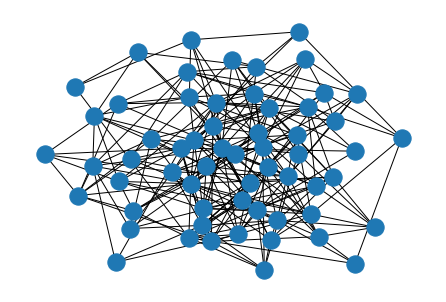

In [71]:
g60 = nx.erdos_renyi_graph(60,0.15)
nx.draw(g60)

In [76]:
graph60 = list(g60.edges)
W60 = np.random.randint(1,60,size=(60,60))
short60 = ss_shortest_path(60,W60,graph60,start=1)

In [77]:
short60

[[[1, 3, 5, 0],
  [1],
  [1, 8, 22, 2],
  [1, 3],
  [1, 13, 6, 4],
  [1, 3, 5],
  [1, 24, 11, 6],
  [1, 58, 7],
  [1, 8],
  [1, 24, 9],
  [1, 24, 11, 10],
  [1, 24, 11],
  [1, 12],
  [1, 13],
  [1, 24, 17, 14],
  [1, 24, 15],
  [1, 24, 28, 4, 23, 19, 16],
  [1, 24, 17],
  [1, 18],
  [1, 8, 16, 19],
  [1, 20],
  [1, 21],
  [1, 24, 33, 2, 22],
  [1, 21, 57, 48, 23],
  [1, 24],
  [1, 25],
  [1, 26],
  [1, 24, 11, 6, 27],
  [1, 24, 28],
  [1, 29],
  [1, 24, 17, 4, 30],
  [1, 24, 31],
  [1, 24, 17, 14, 32],
  [1, 24, 33],
  [1, 52, 34],
  [1, 35],
  [1, 18, 36],
  [1, 24, 37],
  [1, 45, 38],
  [1, 58, 7, 39],
  [1, 21, 40],
  [1, 3, 43, 41],
  [1, 45, 51, 42],
  [1, 58, 43],
  [1, 52, 34, 44],
  [1, 45],
  [1, 24, 17, 46],
  [1, 24, 11, 10, 47],
  [1, 21, 57, 48],
  [1, 24, 11, 49],
  [1, 24, 28, 50],
  [1, 45, 51],
  [1, 52],
  [1, 24, 17, 54, 53],
  [1, 21, 57, 54],
  [1, 24, 17, 55],
  [1, 45, 51, 56],
  [1, 21, 57],
  [1, 58],
  [1, 21, 59]],
 [32,
  0.0,
  60,
  9,
  125,
  28,
  41,
 

In [79]:
for i in graph60:
    g60[i[0]][i[1]]["weight"] = W60[i[0],i[1]]
nx.shortest_path(g60,1,16,weight="weight")

[1, 45, 51, 16]

In [84]:
shortest_path(60,W60,graph60,start=1,end=16)

[[1, 45, 51, 16], 45]

In [82]:
W60[1,24]+W60[24,28]+W60[4,28]+W60[4,23]+W60[19,23]+W60[16,29]

112

In [83]:
W60[1,45]+W60[45,51]+W60[16,51]

45

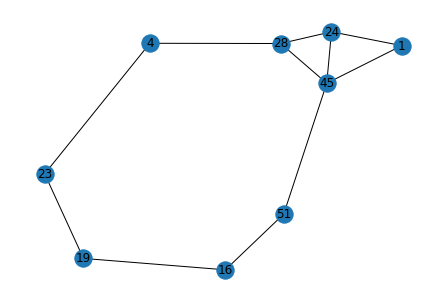

In [81]:
nx.draw(g60.subgraph([1, 45, 51, 24, 28, 4, 23, 19, 16]),with_labels=True)

In [54]:
short100[0][:10]

[[1, 62, 22, 49, 15, 2, 81, 29, 88, 31, 25, 38],
 [1],
 [1, 62, 22],
 [1, 3],
 [1, 96, 4],
 [1, 5],
 [1, 62, 22, 49, 20, 66, 72, 60, 57, 38],
 [1, 5, 7],
 [1, 62, 22, 49, 20, 76, 8],
 [1, 62, 22, 49, 20, 76, 73, 29, 99, 41, 9]]

In [51]:
shortest_path(100,W100,graph100,start=1,end=2)

[[1, 62, 22, 49, 15, 2], 116]

In [24]:
[i for i in short100 if len(i) ==1]

[[1]]

In [34]:
short100[2]

[1, 2, 20, 22, 29, 38, 49, 57, 62, 66, 71, 72, 73, 76, 81, 82, 83]

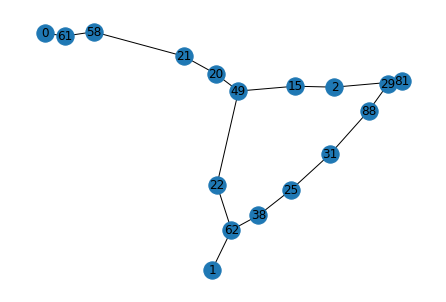

In [57]:
sub100 = g100.subgraph([1, 62, 22, 49,20,21,58,61,0, 15, 2, 81, 29, 88, 31, 25, 38])
nx.draw(sub100,with_labels=True)

In [29]:
adjacent_matrix(graph,100)

[1, 2, 3, 4, 5]

In [32]:
adjacent = adjacent_matrix(graph100,100)
station_list = short100
start = 1
path_list = []
dist_list = []
for i in range(100):
    path = [start]
    unvisit = deepcopy(station_list[i])
    unvisit.remove(start)
    num = len(station_list[i])
    
    for rounds in range(1,num):
        for s in unvisit:
            if adjacent[s,path[-1]] == 1:
                path.append(s)
                unvisit.remove(s)
    path_list.append(path)
        
    shortest_dist = np.sum([W100[path[i],path[i+1]] for i in range(len(path)-1)])
    dist_list.append(shortest_dist)
path_list[:10]

[[1, 62, 22, 49, 20, 21, 58, 61, 0],
 [1],
 [1, 62, 22, 49, 20, 66, 72, 83],
 [1, 3],
 [1, 96, 4],
 [1, 5],
 [1, 62, 22, 49, 15, 2, 81, 29, 73, 32],
 [1, 5, 7],
 [1, 62, 22, 49, 20, 76, 8],
 [1, 62, 22, 49, 20, 66, 72]]

In [56]:
nx.shortest_path(g100,1,0,weight="weight")

[1, 62, 22, 49, 20, 21, 58, 61, 0]

In [67]:
n = 4 
W = np.array([[0,1,2,3],
             [1,0,4,5],
             [2,4,0,6],
             [3,5,6,0]])
graph = [(0,1),(0,2),(2,3)]
short4 = shortest_path(100,W100,graph100,start=1,end=0)

In [68]:
short4

[[1, 62, 22, 49, 20, 21, 58, 61, 0], 339]

In [69]:
W100[1,62]+W100[62,22]+W100[22,49]+W100[49,20]+W100[20,21]+W100[21,58]+W100[58,61]+W100[61,0]

339

In [56]:
g100[1][62]+g100[62][22]+g100[22][49]+g100[49][20]+g100[20][21]+g100[21][58]+g100[58][61]+g100[61][0]

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [60]:
nx =[g100[short4[0][i]][short4[0][i+1]]["weight"] for i in range(len(short4[0])-1)]
py = [W100[short4[0][i]][short4[0][i+1]] for i in range(len(short4[0])-1)]
np.array(nx) == np.array(py)

array([ True, False,  True,  True,  True,  True,  True, False])

In [64]:
g100[22][62]["weight"]

90

In [63]:
W100[62,22]

24

In [22]:
end,start = 0,1
y = np.array([1 if i in [1,0,3,62] else 0 for i in range(100)])
term1 = 0.5*np.dot(y,np.dot(adjacent_matrix(graph100,100),y.transpose()))
term2 = np.sum([y[k] for k in range(100) if (k!=end) and (k!=start)])
term1 - term2

1.0

In [72]:
nx.shortest_path_length(g100,1,0,weight="weight")
#nx.shortest_path(g100,1,0)

351

In [181]:
n = 10
graph = chosen_edge
adjacent = np.zeros((n,n))
for edge in graph:
    adjacent[edge[0],edge[1]] = 1
    adjacent[edge[1],edge[0]] = 1
short10 = shortest_path(n,W10,graph,adjacent,start=4,end=5)

In [300]:
n = 10
graph = chosen_edge
adjacent = np.zeros((n,n))
for edge in graph:
    adjacent[edge[0],edge[1]] = 1
    adjacent[edge[1],edge[0]] = 1
short10_2 = shortest_path(n,W10,graph,adjacent,start=7,end=9)

In [346]:
short10_2[1]

1.0

In [344]:
short10[1]

16.5

In [220]:
W10[0,7]+W10[0,1]+W10[1,5]+W10[4,7]

7

In [221]:
valid_weight = W10*adjacent
y = np.array([1,1,0,0,1,1,0,1,0,0])
0.5*np.dot(y,np.dot(a,y.transpose()))
#np.dot(valid_weight,y.transpose())

7.0

In [222]:
n = 10
graph = solu3[0][0]
adjacent_list = adjacent_matrix(solu3[0],n)
short10_3 = shortest_path(n,W10_3,graph,adjacent_list[0],start=0,end=9)
short10_3[0]

[6, 7, 8, 0, 9]

In [540]:
ad10_3

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]])

[6, 7, 8, 0, 9]

In [551]:
ad10_3 = adjacent_matrix(solu3[0][0],10)
station = [0,9,7, 8, 6]
num = len(station)
path = [0]
#for i in range(4):
while len(path) < num:
    for s in station[1:]:
        if (ad10_3[s,path[-1]] == 1) and (s not in path):
            path.append(s)
path

[0, 8, 6, 7, 9]

In [277]:
n = 15
W15 = np.random.randint(1,10,size=(15,15))
w15 = np.random.randint(1,10,15)
graph15 = mini_overall_dist(n,W15,w15)
connected_graph(15,graph15)

C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[[(0, 6),
  (1, 11),
  (2, 9),
  (3, 8),
  (4, 11),
  (4, 13),
  (5, 6),
  (5, 7),
  (5, 8),
  (5, 14),
  (8, 11),
  (9, 11),
  (9, 12),
  (10, 12)]]

In [290]:
trial = connected_graph(15,graph15)[0]
adjacent15 = np.zeros((15,15))
for edge in trial:
    adjacent15[edge[0],edge[1]] = 1
    adjacent15[edge[1],edge[0]] = 1
short15 = shortest_path(15,W15,trial,adjacent15,start=10,end=13)

C:\Users\keygo\Anaconda3\envs\qiskit44\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [291]:
short15[0]

[10, 13, 4, 9, 11, 12]

In [303]:
n = 20
W20 = np.random.randint(1,10,size=(20,20))
w20 = np.random.randint(1,10,20)
graph20 = mini_overall_dist(n,W20,w20)

In [307]:
len(graph20)

74

In [276]:
first_graph = deepcopy(graph20[0])
new_graph_list=[]
for i in range(20):
    for j in range(i+1,20):
        if (i,j) not in first_graph:
            first_graph.append((i,j))
            adjacent = np.zeros((n,n))
            for edge in first_graph:
                adjacent[edge[0],edge[1]] = 1
                adjacent[edge[1],edge[0]] = 1
        
            power = [np.linalg.matrix_power(adjacent, k) for k in range(1,20)]
            summ = 0
            for p in power:
                summ += p
            validity = np.prod(summ)
            if validity != 0:
                new_graph_list.append(first_graph)
            first_graph = deepcopy(graph20[0])
new_graph_list

[]

In [354]:
#len(connected_graph(20,graph20))
total_length20 = [np.sum([W20[edge[0],edge[1]] for edge in graph]) for graph in connected_graph(20,graph20)]

In [397]:
print(nx.average_shortest_path_length(G20,weight="weight"))
print(avg_length20[5])

2.8210526315789473
5.405263157894737


In [396]:
print(np.sum(W20[[np.triu_indices(20)]]))
print(total_length20[5])

42210
27


In [357]:
np.argsort(avg_length20+total_length20)

array([ 5, 15,  3,  8,  6, 12, 18,  2, 10,  4, 19, 13,  7, 16, 14,  1,  0,
       17, 11,  9, 20, 24, 25, 26, 27, 29, 36, 33, 34, 35, 31, 23, 28, 40,
       37, 38, 21, 22, 39, 32, 30, 41], dtype=int64)

In [365]:
np.argsort(np.array(avg_length20)*np.array(total_length20))

array([ 5, 15,  3,  8,  6, 12,  4,  2, 10, 13, 19, 14,  7, 18, 16,  1,  0,
       17, 11,  9, 20], dtype=int64)

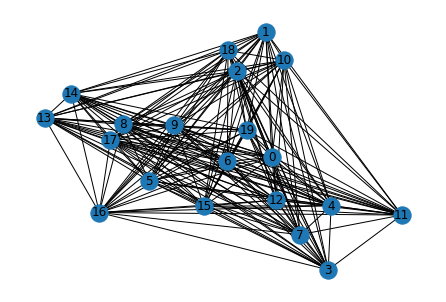

In [376]:
G20 = nx.Graph()
for i in range(n):
    G20.add_node(i)
for j in range(n):
    for k in range(j+1,n):
        G20.add_edge(j,k)

for i in range(n):
    for j in range(i+1,n):
        G20[i][j]["weight"] = W20[i][j]

plt.figure(figsize=(6,4))
nx.draw(G20,pos = pos20,with_labels=True)

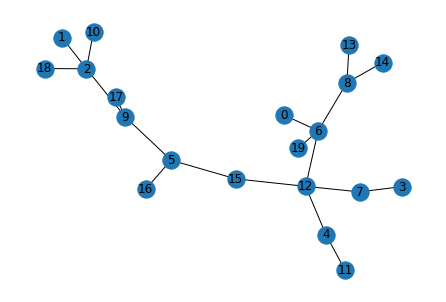

In [378]:
best_network = connected_graph(20,graph20)[5]
g20 = nx.Graph()
n=20
for i in range(n):
    g20.add_node(i)
for j in best_network:
    g20.add_edge(j[0],j[1])

for i in best_network:
    g20[i[0]][i[1]]["weight"] = W20[i[0]][i[1]]

pos20 = nx.spring_layout(g20,weight="length") #weight="length" positions the nodes at correct relative distances
plt.figure(figsize=(6,4))
nx.draw(g20,pos = pos20,with_labels=True)

In [450]:
g20[2]

AtlasView({2: {'color': 'black', 'weight': 1}})

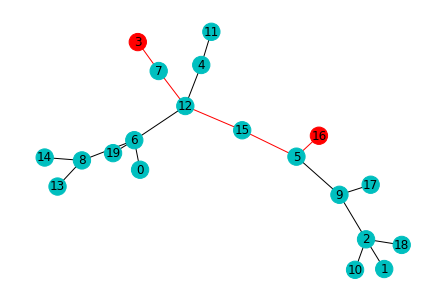

In [456]:
best_network = connected_graph(20,graph20)[5]
g20 = nx.Graph()
n=20
for i in range(n):
    if i in [3,16]:
        g20.add_node(i,color="r")
    else:
        g20.add_node(i,color="b")
for j in best_network:
    if (j[0] in [3,7,15,16]) or (j[1] in [3,7,15,16]):
        g20.add_edge(j[0],j[1],color="r")
    else:
        g20.add_edge(j[0],j[1],color="black")

for i in best_network:
    g20[i[0]][i[1]]["weight"] = W20[i[0]][i[1]]

edges = g20.edges()
edge_colors = [g20[u][v]['color'] for u,v in edges]
nodes = g20.nodes()
node_colors = ["c"]*3+['red']+["c"]*12+["r"]+["c"]*3

pos20 = nx.spring_layout(g20,weight="length") #weight="length" positions the nodes at correct relative distances
plt.figure(figsize=(6,4))
nx.draw(g20,pos = pos20,edge_color=edge_colors,node_color=node_colors,with_labels=True)

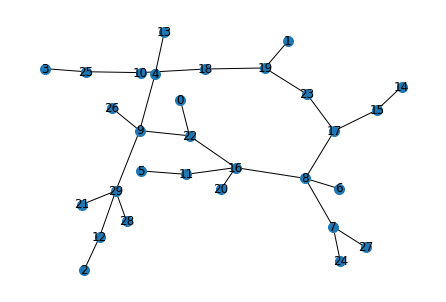

In [418]:
best_network30 = graph30[0]
g30 = nx.Graph()
n=30
for i in range(n):
    g30.add_node(i)
for j in best_network30:
    g30.add_edge(j[0],j[1])

for i in best_network30:
    g30[i[0]][i[1]]["weight"] = W30[i[0]][i[1]]

#pos20 = nx.spring_layout(g20,weight="length") #weight="length" positions the nodes at correct relative distances
plt.figure(figsize=(6,4))
nx.draw(g30,pos = nx.spring_layout(g30,weight="length"),with_labels=True,node_size=100)

In [387]:
nx.shortest_path_length(g20, source=1, target=3) 

7

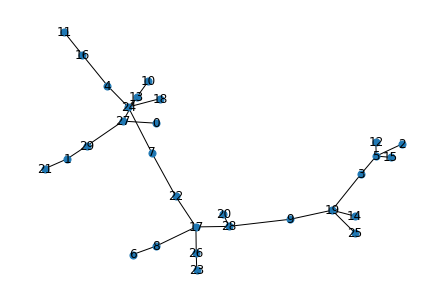

In [51]:
nx.draw(g30,with_labels=True,node_size=50)

In [392]:
W20[1][13]

5

In [363]:
shortest_path(20,W20,best_network,adjacent_matrix([best_network],20)[0],start=17,end=18)

[[17, 18, 2, 9], 5.0]

In [459]:
nx.shortest_path(g30,27,14)

[27, 7, 8, 17, 15, 14]

Use Genetic algorithm to minimize transfer time & overhead of connections

In [11]:
def generate_population(n,nx_graph,popu_size):
    #create a list of odd connection nodes
    terminal = [i for i in range(n) if np.sum(adjacent_matrix(list(nx_graph.edges),n)[i,:]) in [1,3]]
    # shuffle the nodes randomly to form different lines
    population = [random.sample(terminal,len(terminal)) for i in range(popu_size)]
    return population

In [32]:
chromo = [12, 10, 2, 21, 11, 13, 27, 25, 15, 28, 6, 23, 0, 18, 14, 20]
generate_population(30,g30,popu_size=5)

[[12, 10, 2, 21, 11, 13, 27, 25, 15, 28, 6, 23, 0, 18, 14, 20],
 [27, 23, 12, 14, 25, 2, 10, 28, 6, 18, 13, 21, 0, 15, 11, 20],
 [20, 14, 6, 18, 13, 15, 11, 10, 21, 12, 25, 23, 2, 27, 0, 28],
 [20, 21, 10, 2, 0, 15, 25, 13, 6, 12, 28, 23, 18, 27, 11, 14],
 [25, 20, 27, 21, 12, 6, 15, 2, 13, 0, 14, 18, 28, 23, 11, 10]]

In [585]:
if len(start_line.intersection(end_line)) !=0:
    print(1)

In [593]:
chromo = [2,21,12,15,14,25,20,28,6,23,11,18,10,13,0,27]
chromo = [10,21,0,11,13,23,18,20,6,9,28,12,14,25,2,15]
def transfer_freq(nx_graph,chromo,start,end):
    
    lines = [set(nx.shortest_path(nx_graph,chromo[2*i],chromo[2*i+1])) for i in range(int(len(chromo)/2))]
    nl = len(lines)

    short = set(nx.shortest_path(nx_graph,start,end))

    #adjacet matrix of lines
    ad = np.zeros((nl,nl))
    for i in range(nl):
        for j in range(nl):
            if len(lines[i].intersection(lines[j])) != 0:
                ad[i,j] = 1
            else:
                ad[i,j] = 0
    for i in range(nl):
        ad[i,i] = 0

    start_line = set([i for i in range(nl) if start in lines[i]]) #lines that go through start station
    end_line = set([i for i in range(nl) if end in lines[i]]) #lines that go through end station

    if len(start_line.intersection(end_line)) !=0: #if any line goes through both start and end then no need to transfer
        transfer  = 0
    else:
        possible =[] #possible transfer combination for each starting line i
        for i in list(start_line):
            route=[i]  #history of line itenary
            current=i  #current line one is at
            uni = set().union(*[lines[k] for k in route])  #the union of all the valid lines explored so far
            while short.issubset(uni) == False:   #when the union has not convered the shortest path yet, continue
                neighbors = np.where(ad[current,:] == 1)[0]  #neighboring lines of current line
                crossing = [uni.union(lines[j]) for j in neighbors]   #try out the union with neighboring lines
                num_intersect = [len(s.intersection(short)) for s in crossing] #number of intersecting elements with short
                best = neighbors[np.argmax(num_intersect)]  #take out the line with the most intersecting elements
                route.append(best)
                current = best
                uni = set().union(*[lines[k] for k in route])
                if np.max(num_intersect) == len(short):   #if every station on the shortest path is coverd, stop
                    break
            possible.append(route)
        transfer = np.min([len(r)-1 for r in possible]) #shortest itenary -1 is the trnasfer time
    return transfer

In [596]:
len(g30.nodes)

30

In [604]:
def fitness(nx_graph,W,chromo):
    
    n = len(nx_graph.nodes)
    ad = adjacent_matrix(list(nx_graph.edges),n)
    W_ad = ad*W
    
    lines = [nx.shortest_path(nx_graph,chromo[2*i],chromo[2*i+1]) for i in range(int(len(chromo)/2))]
    nl = len(lines)
    inter_groups = {f"inter{i}{j}":list(set(lines[i]).intersection(lines[j])) for i in range(nl) for j in range(i+1,nl)}
    
    stations = []
    for i in range(nl):
        stations += lines[i]
         
    if set(stations) != set(range(n)): #if the lines do not cover all the stations then it's invalid
        fitness = 10000000
        
    else:
        fitness = np.mean([transfer_freq(nx_graph,chromo,i,j) for i in range(n) for j in range(i+1,n)])
    
    #calculate increased overall length of the network
    plus = [np.sum([W_ad[item[i],item[j]] for i in range(len(item)) for j in range(i+1,len(item))]) for key,item in inter_groups.items()]
    increase = np.sum(plus)
    
    return fitness+increase/10

In [368]:
def fitness(nx_graph,W,chromo):
    
    n = W.shape[0]
    ad = adjacent_matrix(list(nx_graph.edges),n)
    W_ad = ad*W 
    #A list of lines for this specific chromo
    lines = [nx.shortest_path(nx_graph,chromo[2*i],chromo[2*i+1]) for i in range(int(len(chromo)/2))]
    nl = len(lines) #number of lines
    #transfer_points on each line
    line_transfer = [[p for p in lines[i] if np.sum(adjacent_matrix(list(nx_graph.edges),n)[p,:])>=3] for i in range(nl)]
    non_transfer = [[p for p in lines[i] if np.sum(adjacent_matrix(list(nx_graph.edges),n)[p,:])<=2] for i in range(nl)]
    
    stations = []
    for i in range(nl):
        stations += lines[i]
        
    paircount = 0   
    if set(stations) != set(range(n)): #if the lines do not cover all the stations then it's invalid
        fitness = 10000000
    else:
        #intersection between two lines
        inter_groups = {f"inter{i}{j}":list(set(lines[i]).intersection(lines[j])) for i in range(nl) for j in range(i+1,nl)}
    
        fitness = 0
        for i in range(nl):
            for j in range(i+1,nl):
                if len(inter_groups[f"inter{i}{j}"])>0: #if there are intersections between i and j lines
                    transfer = 1
                    #ni = len(inter_groups[f"inter{i}{j}"])  #number of intersections
                    nn = len(set(non_transfer[i]).intersection(non_transfer[j]))
                    ni = len(line_transfer[i])
                    nj = len(line_transfer[j])
                    #fitness += transfer*(len(lines[i])-ni)*(len(lines[j])-ni)
                    fitness += transfer*(len(lines[i])-ni-nn)*(len(lines[j])-nj-nn)
                    paircount += (len(lines[i])-ni-nn)*(len(lines[j])-nj-nn)
                    #paircount += (len(lines[i])-ni)*(len(lines[j])-ni)
                else:
                    p = nx.shortest_path(nx_graph,lines[i][0],lines[j][0]) #the first node in every line is the endpoint
                    #see how many times intersection points are traversed through
                    count = [1 for s in range(nl) for k in range(s+1,nl) if set(inter_groups[f"inter{s}{k}"]).issubset(set(p))]
                    transfer = len(count)
                    ni = len(line_transfer[i]) #number of transfer points on line i
                    nj = len(line_transfer[j])
                    fitness += transfer*(len(lines[i])-ni)*(len(lines[j])-nj)
                    paircount += (len(lines[i])-ni)*(len(lines[j])-nj)
                #ni = len(inter_groups[f"inter{i}{j}"])  #number of intersections
                #fitness += transfer*(len(lines[i])-ni)*(len(lines[j])-ni)
                
        #calculate increased overall length of the network
        plus = [np.sum([W_ad[item[i],item[j]] for i in range(len(item)) for j in range(i+1,len(item))]) for key,item in inter_groups.items()]
        increase = np.sum(plus)
    
    #still need to consider the transfer time from one transfer point to another line
    transfer_points = [i for i in range(n) if np.sum(adjacent_matrix(list(nx_graph.edges),n)[i,:]) >= 3]
    nt = len(transfer_points)
    #paircount += nt*(nt-1)/2
    
    for i in transfer_points:
        for j in [l for l in range(nl) if i not in lines[l]]: #iterate over lines that i is not on
            intersect = []
            for k in line_transfer[j]:
                path = nx.shortest_path(nx_graph,i,k)
                intersect.append(len(set(path).intersection(transfer_points)))
            fitness += 0.5*np.sum([i-2 for i in intersect])  #total transfer times from transfer point ot transfer point
            fitness += (len(lines[j])-len(line_transfer[j]))*(np.min(intersect)-1) #transfer time from transfer point to normal point
            paircount += len(lines[j])-len(line_transfer[j])
    #fitness += np.sum([nx.shortest_path_length(nx_graph,transfer_points[i],transfer_points[j])-1 for i in range(nt) for j in range(i+1,nt)])  
    paircount += len(transfer_points)*(len(transfer_points)-1)/2
    #normalize = paircount
    normalize = n*(n-1)/2
    fitness = fitness/normalize
    
    
    #return fitness+increase/10   #The importance of 2 criteria can be discussed
    return [fitness,paircount]

In [527]:
np.mean(W30[np.triu_indices(30)])

7.559139784946237

In [603]:
chromo = [12, 10, 2, 21, 11, 13, 27, 25, 15, 28, 6, 23, 0, 18, 14, 20]
chromo = [0,21,10,27,6,13,11,18,20,23,19,28,14,25,12,19,2,15]
chromo = [2,21,12,15,14,25,20,28,6,23,11,18,10,13,0,27]
fitness(g30,W30,chromo)

0.9011494252873563

In [16]:
def selection(popu,fitness,nx_graph,W,selection_rate):
    sample_size = round(len(popu)*selection_rate)
    fitness_score = [fitness(nx_graph,W,chromo) for chromo in popu]
    best_chromo = np.argsort(fitness_score)[:sample_size]  #take out the smaller ones
    parents = [popu[i] for i in best_chromo]
    return parents

In [518]:
gen = generate_population(30,g30,popu_size=10)
parents = selection(gen,fitness,g30,W30,0.3)
parents

[[24, 22, 1, 2, 13, 7, 0, 27, 21, 19, 3, 26, 17, 28, 6, 20, 5, 14],
 [26, 14, 2, 17, 6, 13, 5, 1, 27, 28, 0, 22, 24, 3, 20, 7, 19, 21],
 [3, 5, 2, 20, 24, 0, 17, 26, 6, 7, 14, 27, 19, 28, 22, 21, 13, 1]]

In [17]:
def crossover(parents,popu_size):
    
    offspring = parents
    for i in range(popu_size-len(parents)):
        par = random.sample(range(len(parents)),1)[0]
        selected = parents[par]
        indices = random.sample(range(len(parents[0])),2)
        cross_par = deepcopy(selected)
        cross_par[indices[0]],cross_par[indices[1]] = cross_par[indices[1]],cross_par[indices[0]]
        offspring.append(cross_par)
    return offspring

In [521]:
crossover(parents,10)

[[24, 22, 1, 2, 13, 7, 0, 27, 21, 19, 3, 26, 17, 28, 6, 20, 5, 14],
 [26, 14, 2, 17, 6, 13, 5, 1, 27, 28, 0, 22, 24, 3, 20, 7, 19, 21],
 [3, 5, 2, 20, 24, 0, 17, 26, 6, 7, 14, 27, 19, 28, 22, 21, 13, 1],
 [26, 14, 2, 17, 6, 13, 5, 1, 27, 28, 22, 0, 24, 3, 20, 7, 19, 21],
 [26, 14, 2, 17, 27, 13, 5, 1, 6, 28, 22, 0, 24, 3, 20, 7, 19, 21],
 [3, 5, 2, 20, 24, 0, 17, 26, 6, 7, 14, 21, 19, 28, 22, 27, 13, 1],
 [26, 14, 2, 17, 6, 13, 5, 1, 27, 28, 0, 21, 24, 3, 20, 7, 19, 22],
 [26, 14, 2, 17, 5, 13, 6, 1, 27, 28, 22, 0, 24, 3, 20, 7, 19, 21],
 [3, 5, 2, 20, 24, 0, 17, 26, 6, 7, 14, 21, 19, 28, 22, 13, 27, 1],
 [3, 5, 2, 20, 27, 0, 17, 26, 6, 7, 14, 24, 19, 28, 22, 21, 13, 1]]

In [138]:
#the standard deviation of the top 30% of the population
def top_std(popu,fitness,nx_graph,W):
    fitness_score = [fitness(nx_graph,W,chromo) for chromo in popu]
    return np.std(np.sort(fitness_score)[:round(len(popu)*0.3)])

In [18]:
def train_line_genetic(n,nx_graph,popu_size,fitness,W,selection_rate,max_iteration,cutoff_std):
    
    popu = generate_population(n,nx_graph,popu_size)
    
    best_individual=[]
    mini_fit = []
    iteration = 0
    while iteration < max_iteration:
        iteration += 1
        parents = selection(popu,fitness,nx_graph,W,selection_rate)
        offspring = crossover(parents,popu_size)
        popu = offspring
        
        fitness_score = [fitness(nx_graph,W,chromo) for chromo in popu]
        best = popu[np.argmin(fitness_score)]
        mini_fit.append(np.min(fitness_score))
        best_individual.append(best)
        
        if top_std(popu,fitness,nx_graph,W) < cutoff_std:
            break
    
    optimal = best_individual[np.argmin(mini_fit)]
    optimal = [nx.shortest_path(nx_graph,optimal[2*i],optimal[2*i+1]) for i in range(int(len(optimal)/2))]
    print("minimum cost:",np.min(mini_fit))
    print("optimal lines:",optimal)
    print("iteration:",iteration)
    
    return [optimal,mini_fit]
    

In [230]:
optimal = [20, 21, 10, 2, 0, 15, 25, 13, 6, 12, 28, 23, 18, 27, 11, 14]
optimal = [nx.shortest_path(g30,optimal[2*i],optimal[2*i+1]) for i in range(int(len(optimal)/2))]

In [605]:
test1 = train_line_genetic(30,g30,500,fitness,W30,selection_rate=0.3,max_iteration=100,cutoff_std=0.1)

minimum cost: 0.9011494252873563
optimal lines: [[20, 28], [21, 1, 29, 27, 13, 24, 7, 22, 17, 28, 9, 19, 3, 5, 15], [14, 19, 25], [27, 0], [10, 13], [11, 16, 4, 24, 18], [12, 5, 2], [6, 8, 17, 26, 23]]
iteration: 18


In [ ]:
test100 = train_line_genetic(100,g_final,500,fitness,W100,selection_rate=0.3,max_iteration=30,cutoff_std=0.5)

In [205]:
test2 = train_line_genetic(30,g30,500,fitness,W30,selection_rate=0.3,max_iteration=100,cutoff_std=0.1)

minimum cost: 6.28175519630485
optimal lines: [[21, 1, 29, 27, 13, 24, 7, 22, 17, 28, 9, 19, 3, 5, 2], [18, 24, 4, 16, 11], [14, 19, 25], [0, 27], [15, 5, 12], [6, 8, 17, 26, 23], [20, 28], [13, 10]]
iteration: 32


In [560]:
test3 = train_line_genetic(30,g30,500,fitness,W30,selection_rate=0.3,max_iteration=100,cutoff_std=1)

minimum cost: 7.152873563218391
optimal lines: [[0, 22, 9, 29, 12, 2], [20, 16, 22], [19, 1], [3, 25, 10, 18, 19, 23, 17, 8, 16, 22, 9, 26], [5, 11, 16, 22, 9, 4, 13], [28, 29, 9, 22, 16, 8, 17], [14, 15, 17, 8, 16, 22, 9, 29, 21], [24, 7, 27], [6, 8, 7]]
iteration: 1


In [561]:
test4 = train_line_genetic(30,g30,500,fitness,W30,selection_rate=0.3,max_iteration=100,cutoff_std=0.5)

minimum cost: 6.028735632183908
optimal lines: [[26, 9, 29, 28], [20, 16, 22, 0], [27, 7], [19, 1], [3, 25, 10, 18, 19, 23, 17, 8, 16, 22, 9, 4, 13], [6, 8, 16, 11, 5], [22, 9, 29, 12, 2], [14, 15, 17, 8, 16, 22, 9, 29, 21], [17, 8, 7, 24]]
iteration: 5


In [570]:
test5 = train_line_genetic(30,g30,500,fitness,W30,selection_rate=0.3,max_iteration=100,cutoff_std=0.5)

minimum cost: 6.005747126436782
optimal lines: [[14, 15, 17, 8, 16, 22, 9, 4, 13], [1, 19], [7, 27], [22, 9, 29, 21], [5, 11, 16, 20], [6, 8, 16, 22, 0], [28, 29, 9, 26], [3, 25, 10, 18, 19, 23, 17, 8, 16, 22, 9, 29, 12, 2], [17, 8, 7, 24]]
iteration: 4


In [598]:
trans30.edges

EdgeView([(7, 8), (8, 16), (8, 17), (9, 22), (9, 29), (16, 22)])

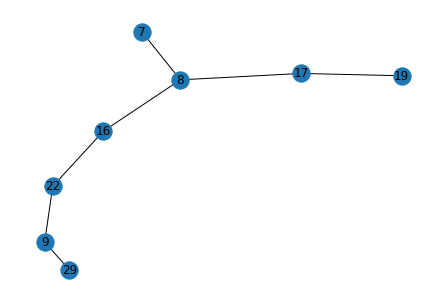

In [616]:
trans30 = g30.subgraph([i for i in range(n) if np.sum(adjacent_matrix(list(g30.edges),n)[i,:]) >= 3]).copy()
trans30.add_edge(19,17)
nx.draw(trans30,with_labels=True)

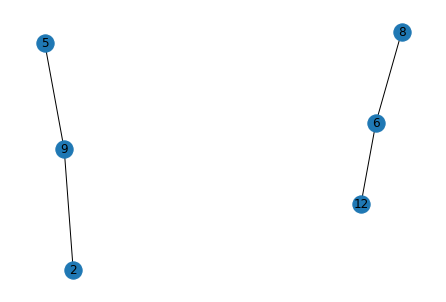

In [617]:
trans20 = nx.induced_subgraph(g20,[i for i in range(n) if np.sum(adjacent_matrix(list(g20.edges),n)[i,:]) >= 3])
nx.draw(trans20,with_labels=True)

In [620]:
trans_points = [i for i in range(n) if np.sum(adjacent_matrix(list(g30.edges),n)[i,:]) >= 3]
[[u for u in g30.neighbors(i)] for i in trans_points]

[[8, 24, 27],
 [6, 7, 16, 17],
 [4, 22, 26, 29],
 [8, 11, 20, 22],
 [8, 15, 23],
 [1, 18, 23],
 [0, 9, 16],
 [9, 12, 21, 28]]

In [609]:
nx.is_connected(g20)

True

In [533]:
chromo = [27, 28, 17, 22, 1, 19, 3, 21, 14, 26, 7, 13, 6, 5, 24, 2, 20, 0]
[nx.shortest_path(g30,chromo[2*i],chromo[2*i+1]) for i in range(int(len(chromo)/2))]

[[27, 7, 8, 16, 22, 9, 29, 28],
 [17, 8, 16, 22],
 [1, 19],
 [3, 25, 10, 18, 19, 23, 17, 8, 16, 22, 9, 29, 21],
 [14, 15, 17, 8, 16, 22, 9, 26],
 [7, 8, 16, 22, 9, 4, 13],
 [6, 8, 16, 11, 5],
 [24, 7, 8, 16, 22, 9, 29, 12, 2],
 [20, 16, 22, 0]]

In [ ]:
#each element in this list is a list of lines for each configuration(chromosome)
lines = [[nx.shortest_path(nx_graph,config[2*i],config[2*i+1]) for i in range(len(popu[0])/2)] for config in popu]

In [469]:
[i for i in range(30) if np.sum(adjacent_matrix(list(g30.edges),30)[i,:]) in [1,3]]

[0, 1, 2, 3, 5, 6, 7, 13, 14, 17, 19, 20, 21, 22, 24, 26, 27, 28]

In [114]:
np.array(range(6))

array([0, 1, 2, 3, 4, 5])

Use equal passenger loading as critera to assign lines

In [382]:
def train_line_equal_load(n,Wn,nx_graph):  #Wn here is the weight of the station
    
    cqm = ConstrainedQuadraticModel()
    
    A = adjacent_matrix(list(nx_graph.edges),n)
    connections = np.array([np.sum(A[i,:]) for i in range(n)]) #number of connections on each station
    wn = Wn/connections # the reduced load of each station
    
    trans_points = [i for i in range(n) if np.sum(A[i,:]) >= 3]
    non_trans = [i for i in range(n) if np.sum(A[i,:]) <= 2]
    nl = len(trans_points)+1 #number of lines
    avg = np.sum(Wn)/nl
    
    terminal = [i for i in range(n) if np.sum(A[i,:]) in [1,3]] #terminal stations
    non_terminal = [i for i in range(n) if np.sum(A[i,:]) not in [1,3]]
    non_termi = np.array([1 if i in non_terminal else 0 for i in range(n)])
    
    x = np.array([Binary(f"x{i}{j}") for i in range(nl) for j in range(n)]).reshape(nl,n)
    
    #minimize the difference between sum of weights and average weight
    #objective = quicksum([(quicksum([x[i][j]*wn[j] for j in range(n)])-avg)**2 for i in range(nl)])
    objective = 0
    for k in range(nl):
        for s in range(k+1,nl):
            objective += (quicksum([x[k][j]*wn[j] for j in range(n)])-quicksum([x[s][j]*wn[j] for j in range(n)]))**2
    cqm.set_objective(objective)
    
    #need to form a path (branch roads and crossroads are also included here)
    for i in range(nl):
        term1 = 0.5*np.dot(x[i,:],np.dot(A,x[i,:].transpose()))
        term2 = quicksum([x[i,k] for k in range(n)])
        cqm.add_constraint(term2-term1 == 1)
    
    #each line cannot have any station with more than 2 connections
    for i in range(nl):
        for j in range(n):
            cqm.add_constraint(quicksum(x[i,j]*A[j,:]*x[i,:]) <= 2) #xij*Aj is the adjacent of "chosen" node
    
    #each line cannot have any non terminal station with only one connection (can have 0(terminal to terminal) or 2)
    #for i in range(nl):
        #for j in non_terminal:
            #cqm.add_constraint(quicksum(x[i,j]*non_termi[j]*A[j,:]*x[i,:]) >= 1)
    
    #Each line needs to contain at least 2 terminal stations (3 connection stations are both terminal and intermediate)
    for i in range(nl):
        cqm.add_constraint(quicksum([x[i,terminal[k]] for k in range(len(terminal))]) >= 2)
    
    #each connected pair of stations need to be on at least one same line
    for j in range(n):
        for k in range(j+1,n):
            if A[j,k] == 1:
                cqm.add_constraint(quicksum([x[i,j]*x[i,k] for i in range(nl)]) >= 1)
        
    #every station needs to be covered
    for j in range(n):
        cqm.add_constraint(quicksum([x[k,j] for k in range(nl)]) >= 1)
    #transfer points need to have at least(exactly) 2 lines going through
    for j in trans_points:
        cqm.add_constraint(quicksum([x[k,j] for k in range(nl)]) <=3)
    #non_transfer points need to have exactly 1 line going through
    for j in non_trans:
        cqm.add_constraint(quicksum([x[k,j] for k in range(nl)]) <=2)
    
    token = "DEV-1dce3b9188c2ff50006a0512a0184002b14b4169"
    cqm_sampler = LeapHybridCQMSampler(token=token)
    sampleset = cqm_sampler.sample_cqm(cqm,label="stations_division")
    feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)
    
    data = pd.DataFrame(feasible_sampleset)
    best_index = np.argmin(feasible_sampleset.record.energy)
    best_dict = dict(data.iloc[best_index,:])
    
    line_list=[]
    for i in range(nl):
        line = []
        for j in range(n):
            if best_dict[f"x{i}{j}"] == 1:
                line.append(j)
        line_list.append(line)
    
    return [line_list,feasible_sampleset]

In [383]:
load1 = train_line_equal_load(30,w30,g30)

In [120]:
load2 = train_line_equal_load(30,w30,g30)

In [133]:
load3 = train_line_equal_load(30,w30,g30)

In [ ]:
load4 = train_line_equal_load(30,w30,g30)

In [80]:
sol = load1[1].first.sample
sol_list = []
for i in range(8):
    for j in range(30):
        sol_list.append(sol[f"x{i}{j}"])
np.array(sol_list).reshape(8,30)

array([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0., 0

In [70]:
data = pd.DataFrame(load1[1])
best_index = np.argmin(load1[1].record.energy)
best_dict = dict(data.iloc[best_index,:])
best_index

2

In [58]:
load1[0]

[[2, 3, 5, 14, 19],
 [0, 7, 13, 17, 20, 22, 24, 27, 28],
 [4, 7, 17, 22, 23, 24, 26],
 [7, 9, 10, 13, 17, 19, 22, 24, 28],
 [3, 5, 9, 15, 17, 19, 22, 28],
 [1, 4, 11, 13, 16, 21, 24, 27, 29],
 [6, 7, 8, 17, 18, 22, 24],
 [3, 5, 12, 19, 25]]

In [121]:
load2[0]

[[6, 7, 8, 17, 18, 22, 24],
 [3, 5, 9, 15, 17, 19, 22, 28],
 [7, 9, 10, 13, 17, 19, 22, 24, 28],
 [2, 3, 5, 14, 19],
 [0, 7, 13, 17, 22, 23, 24, 26, 27],
 [3, 5, 12, 19, 25],
 [1, 4, 11, 13, 16, 21, 24, 27, 29],
 [0, 7, 13, 17, 20, 22, 24, 27, 28]]

In [135]:
load3[0]

[[3, 5, 9, 12, 19, 28],
 [2, 5, 15],
 [6, 7, 8, 13, 17, 22, 24],
 [0, 1, 21, 27, 29],
 [17, 20, 23, 26, 28],
 [4, 11, 16, 18, 24],
 [14, 19, 25],
 [10, 13, 27]]

In [373]:
load4[0]

[[2, 3, 5, 9, 17, 19, 26, 28],
 [1, 7, 13, 17, 21, 22, 23, 24, 26, 27, 29],
 [0, 7, 9, 13, 17, 19, 22, 24, 25, 27, 28],
 [1, 7, 9, 13, 14, 17, 19, 22, 24, 27, 28, 29],
 [3, 5, 7, 9, 12, 17, 18, 19, 22, 24, 28],
 [3, 5, 9, 15, 19, 20, 28],
 [6, 7, 8, 10, 13, 17, 22, 24],
 [3, 4, 7, 9, 11, 16, 17, 19, 22, 24, 28]]

In [384]:
load1[0]

[[14, 19, 25],
 [7, 13, 17, 22, 23, 24, 26],
 [6, 8, 9, 17, 28],
 [2, 5, 15],
 [1, 10, 13, 21, 27, 29],
 [7, 17, 18, 20, 22, 24, 28],
 [0, 4, 11, 13, 16, 24, 27],
 [3, 5, 9, 12, 19, 28]]

In [150]:
line1 = [(0, 27),(1, 21),(1, 29),(27, 29)]
line2 = [(10, 13),(13, 27)]
line3 = [(4, 16), (4, 24),(11, 16),(18, 24)]
line4 = [(6, 8), (7, 22), (7, 24),(8, 17),(13, 24),(17, 22)]
line5 = [(17, 26), (17, 28),(20, 28), (23, 26)]
line6 = [(3, 5), (3, 19),(5, 12),(9, 19), (9, 28)]
line7 = [(14, 19),(19,25)]
line8 = [(2,5),(5,15)]

In [157]:
w30

array([ 3,  9, 10,  7, 11, 13, 12,  5,  3,  8,  8,  6,  6,  2,  7,  8,  2,
       13,  2, 11, 10,  3,  1,  6, 12, 10, 10,  8,  2,  1])

In [149]:
g30.edges()

EdgeView([(0, 27), (1, 21), (1, 29), (2, 5), (3, 5), (3, 19), (4, 16), (4, 24), (5, 12), (5, 15), (6, 8), (7, 22), (7, 24), (8, 17), (9, 19), (9, 28), (10, 13), (11, 16), (13, 24), (13, 27), (14, 19), (17, 22), (17, 26), (17, 28), (18, 24), (19, 25), (20, 28), (23, 26), (27, 29)])

In [385]:
A = adjacent_matrix(list(g30.edges),30)
connections = np.array([np.sum(A[i,:]) for i in range(30)]) #number of connections on each station
aa = w30/connections # the reduced load of each station
[np.sum([aa[i] for i in load1[0][j]]) for j in range(8)]

[19.75,
 20.916666666666664,
 21.416666666666668,
 21.25,
 19.333333333333332,
 21.916666666666668,
 21.833333333333332,
 20.166666666666668]

In [250]:
transfer = [i for i in range(30) if np.sum(A[i,:])>=3]
np.sum([aa[i]*2 if i in transfer else aa[i] for i in range(30)])/8

19.0

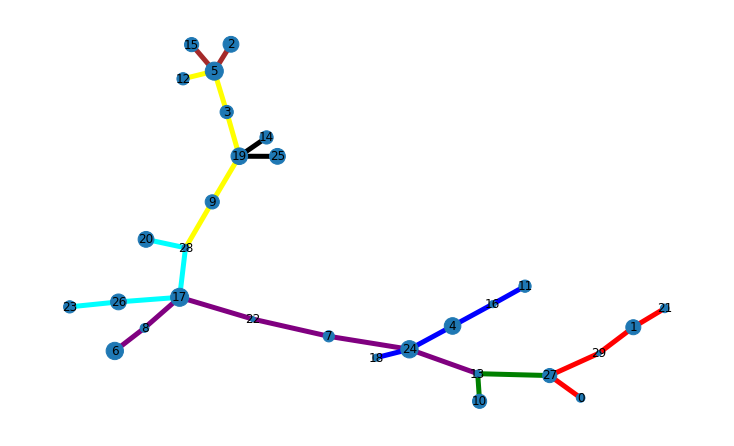

In [223]:
#assigining lines based on traffic volume
edges = g30.edges()
for u,v in edges:
    if (u,v) in line1:
       g30[u][v]['color'] = "red"
    if (u,v) in line2:
       g30[u][v]['color'] = "green"
    if (u,v) in line3:
       g30[u][v]['color'] = "blue"
    if (u,v) in line4:
       g30[u][v]['color'] = "purple"
    if (u,v) in line5:
       g30[u][v]['color'] = "cyan"
    if (u,v) in line6:
       g30[u][v]['color'] = "yellow"
    if (u,v) in line7:
       g30[u][v]['color'] = "black"
    if (u,v) in line8:
       g30[u][v]['color'] = "brown"

plt.figure(figsize=(10,6))
edge_colors = [g30[u][v]['color'] for u,v in edges]
pos30 = nx.spring_layout(g30, weight='length')
nx.draw(g30,pos=pos30,with_labels=True,node_size=25*w30,edge_color = edge_colors,width=5)

(-0.9117994889875887,
 0.8674350667406823,
 -1.0321309493098325,
 1.117335798250809)

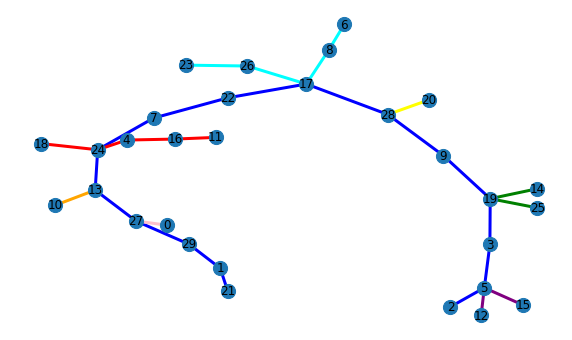

In [219]:
line_combi = [[tuple(np.sort([line[i],line[i+1]])) for i in range(len(line)-1)] for line in test2[0]]
colors = ["red","green","blue","purple","cyan","yellow","black","brown"]
G30 =nx.MultiGraph()
for i in range(30):
    G30.add_node(i)
for i in range(len(line_combi)):
    G30.add_edges_from(line_combi[i],color=colors[i])
    
#edges = G30.edges()
    
#edge_colors = [G30[u][v]['color'] for u,v in edges]
#nx.draw(G30,pos=pos30,with_labels=True,node_size=25*w30,width=5)

plt.figure(figsize=(10,6))
nx.draw_networkx_nodes(G30, pos30,node_size=200)
nx.draw_networkx_labels(G30,pos30)
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.1', edgelist = line_combi[0], width = 3, edge_color='b')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.3', edgelist = line_combi[1], width = 3, edge_color='r')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[2], width = 3, edge_color='g')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[3], width = 3, edge_color='pink')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[4], width = 3, edge_color='purple')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[5], width = 3, edge_color='cyan')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[6], width = 3, edge_color='yellow')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[7], width = 3, edge_color='orange')
plt.axis('off')

IndexError: list index out of range

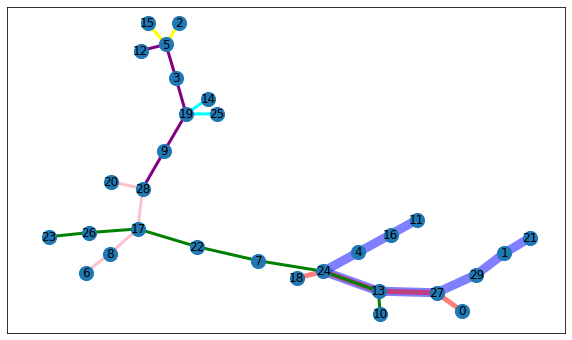

In [613]:
random1 = [[21,1,29,27,13,24,4,16,11],[0,27,13,24,18],[10,13,24,7,22,17,26,23],[6,8,17,28,20],[28,9,19,3,5,12],
           [14,19,25],[2,5,15]]
line_combi = [[tuple(np.sort([line[i],line[i+1]])) for i in range(len(line)-1)] for line in random1]
colors = ["red","green","blue","purple","cyan","yellow","black","brown"]
G30 =nx.MultiGraph()
for i in range(30):
    G30.add_node(i)
for i in range(len(line_combi)):
    G30.add_edges_from(line_combi[i],color=colors[i])
    
#edges = G30.edges()
    
#edge_colors = [G30[u][v]['color'] for u,v in edges]
#nx.draw(G30,pos=pos30,with_labels=True,node_size=25*w30,width=5)

plt.figure(figsize=(10,6))
nx.draw_networkx_nodes(G30, pos30,node_size=200)
nx.draw_networkx_labels(G30,pos30)
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.1', edgelist = line_combi[0], width = 9, edge_color='b',alpha=0.5)
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.3', edgelist = line_combi[1], width = 5, edge_color='r',alpha=0.5)
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[2], width = 3, edge_color='g')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[3], width = 3, edge_color='pink')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[4], width = 3, edge_color='purple')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[5], width = 3, edge_color='cyan')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[6], width = 3, edge_color='yellow')
nx.draw_networkx_edges(G30, pos30,connectionstyle='arc3, rad = 0.5', edgelist = line_combi[7], width = 3, edge_color='orange')
plt.axis('off')

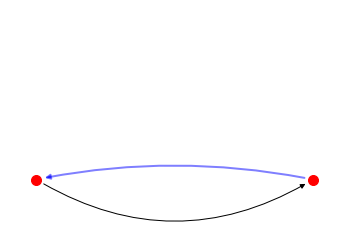

In [196]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from([0,1])
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color = 'r', node_size = 100, alpha = 1)
nx.draw_networkx_edges(G, pos,connectionstyle='arc3, rad = 0.1', edgelist = [(0,1)], width = 2, alpha = 0.5, edge_color='b')
nx.draw_networkx_edges(G, pos,connectionstyle='arc3, rad = 0.3', edgelist= [(1,0)], width = 1, alpha = 1)
plt.axis('off')
plt.show() 

In [231]:
optimal

[[20, 28, 17, 22, 7, 24, 13, 27, 29, 1, 21],
 [10, 13, 24, 7, 22, 17, 28, 9, 19, 3, 5, 2],
 [0, 27, 13, 24, 7, 22, 17, 28, 9, 19, 3, 5, 15],
 [25, 19, 9, 28, 17, 22, 7, 24, 13],
 [6, 8, 17, 28, 9, 19, 3, 5, 12],
 [28, 17, 26, 23],
 [18, 24, 13, 27],
 [11, 16, 4, 24, 7, 22, 17, 28, 9, 19, 14]]

In [206]:
test2[0]

[[21, 1, 29, 27, 13, 24, 7, 22, 17, 28, 9, 19, 3, 5, 2],
 [18, 24, 4, 16, 11],
 [14, 19, 25],
 [0, 27],
 [15, 5, 12],
 [6, 8, 17, 26, 23],
 [20, 28],
 [13, 10]]

In [227]:
chromo = [21,2,18,11,14,25,0,27,15,12,6,23,20,28,13,10]
fitness(g30,W30,chromo)

6.28175519630485

In [93]:
A = adjacent_matrix(list(g30.edges),n)
terminal = [i for i in range(n) if np.sum(A[i,:]) in [1,3]]

In [85]:
[n for n in g30.neighbors(19)]

[3, 9, 14, 25]

In [94]:
terminal

[0, 2, 6, 10, 11, 12, 13, 14, 15, 18, 20, 21, 23, 25, 27, 28]

In [105]:
non_terminal = [i for i in range(n) if np.sum(A[i,:]) not in [1,3]]
non_terminal

[1, 3, 4, 5, 7, 8, 9, 16, 17, 19, 22, 24, 26, 29]

## Important data

In [525]:
g_final.edges

EdgeView([(12, 68), (12, 69), (12, 70), (16, 60), (19, 38), (25, 31), (25, 38), (31, 88), (35, 69), (38, 57), (38, 91), (38, 62), (42, 67), (42, 80), (42, 91), (45, 60), (50, 72), (57, 60), (57, 68), (60, 72), (70, 86), (72, 83), (72, 66), (83, 90), (84, 85), (85, 88), (88, 29), (6, 48), (6, 92), (9, 37), (9, 41), (11, 92), (29, 59), (29, 64), (29, 93), (29, 95), (29, 99), (29, 81), (29, 73), (30, 77), (30, 87), (34, 53), (34, 77), (40, 64), (41, 48), (41, 97), (41, 99), (43, 92), (44, 63), (44, 64), (46, 63), (52, 87), (52, 93), (1, 3), (1, 5), (1, 62), (1, 96), (2, 14), (2, 15), (2, 81), (3, 28), (3, 62), (4, 96), (5, 7), (13, 15), (13, 33), (14, 65), (15, 17), (15, 49), (22, 26), (22, 49), (22, 62), (24, 98), (36, 55), (47, 81), (49, 20), (55, 96), (62, 74), (96, 98), (0, 61), (8, 39), (8, 76), (8, 79), (8, 94), (10, 58), (18, 58), (20, 21), (20, 56), (20, 66), (20, 76), (21, 58), (21, 75), (21, 78), (23, 54), (27, 76), (27, 89), (32, 73), (51, 89), (54, 71), (58, 61), (71, 73), (71

In [528]:
W100

array([[24, 80, 20, ..., 84,  6, 12],
       [30, 57, 33, ...,  6, 62, 97],
       [34, 72, 40, ...,  8,  3, 45],
       ...,
       [95, 77, 32, ..., 42, 88, 26],
       [ 6,  8, 40, ..., 83, 41, 76],
       [13, 97, 61, ..., 90, 62, 55]])

In [529]:
w100

array([ 9, 24,  8, 17, 16, 11, 15,  9,  7, 10,  2,  1,  6, 12, 19,  4,  3,
        7, 23, 18, 17, 24, 15, 19,  5, 22, 16, 20,  3, 23,  4, 20, 21, 21,
       11, 23, 19, 18, 24, 16, 18, 23, 17, 12, 23, 12,  6, 14, 10, 19,  2,
       22, 10, 15, 20,  4,  7, 13,  6, 14, 24,  2, 24, 19, 22, 21, 11, 12,
       14,  1,  2, 21, 13,  7,  7,  6, 24,  8, 12, 21, 22, 19,  7, 15, 21,
       23, 22, 14, 13, 12, 22,  4, 16, 19, 13, 17,  5, 20, 22,  9])

In [530]:
g30.edges

EdgeView([(0, 27), (1, 21), (1, 29), (2, 5), (3, 5), (3, 19), (4, 16), (4, 24), (5, 12), (5, 15), (6, 8), (7, 22), (7, 24), (8, 17), (9, 19), (9, 28), (10, 13), (11, 16), (13, 24), (13, 27), (14, 19), (17, 22), (17, 26), (17, 28), (18, 24), (19, 25), (20, 28), (23, 26), (27, 29)])

In [531]:
W30

array([[ 3,  4,  4, 14,  7, 13, 12, 14, 10,  2,  4,  7, 13,  6,  6, 13,
         1,  3,  8,  3, 10, 11, 12,  4, 11,  5,  1,  1, 14,  5],
       [14, 13, 11,  7, 10, 11,  9,  2, 10, 14,  3,  6, 13, 11, 11,  8,
        11,  9,  5,  6, 11,  2, 13,  2, 14, 14,  5, 13, 12,  3],
       [11, 13,  9,  6,  9,  2,  4,  1, 12, 13, 10,  1,  1,  1,  9, 10,
        11,  5,  2,  5,  7,  2,  2,  7, 11, 11,  5,  8,  9, 11],
       [ 9,  9, 12,  4,  6,  4, 11, 12,  8,  8,  8,  4,  2, 14,  6, 13,
         9,  4, 11,  1,  5,  8,  3, 10,  5,  8, 14,  4,  9, 10],
       [ 7, 11,  2, 11,  7,  6, 13, 12,  6, 11, 12,  1,  6, 14, 12,  8,
         1,  4,  1, 12,  3,  8,  3,  3,  3, 12,  8, 13,  9, 10],
       [ 1,  1, 13,  7,  2,  4,  7,  5,  7,  9,  6,  6,  4, 12,  8,  7,
         5, 12,  7, 12, 13, 14,  8,  9,  7,  9, 13,  9,  3, 12],
       [ 3,  3,  4, 14,  5, 12,  5,  3,  2,  5,  9, 12,  7,  9,  7, 11,
        14, 13,  5, 10,  6, 13, 12,  9, 13,  8,  6,  9, 13, 13],
       [ 8, 10,  5,  4,  1, 11, 12,  4,  

In [532]:
w30

array([ 3,  9, 10,  7, 11, 13, 12,  5,  3,  8,  8,  6,  6,  2,  7,  8,  2,
       13,  2, 11, 10,  3,  1,  6, 12, 10, 10,  8,  2,  1])

In [549]:
line = [0]
unvisit = list(range(1,100))
distance=[]
while len(line)<100:
    i = line[-1]
    check=[W100[i,j] for j in unvisit]
    distance.append(W100[i,j])
    mini = np.argmin(check)
    line.append(unvisit[mini])
    unvisit.remove(unvisit[mini])
np.sum(distance)

5049

In [553]:
a = set([1,2,3])
b = set([3,4,5])
a.union(b)

{1, 2, 3, 4, 5}